# Import Library

In [1]:
# 기본 패키지
import os
import pandas as pd
import numpy as np
from collections import Counter

# 시각화 패키지
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic') 
plt.style.use(['ggplot'])

from scipy.ndimage import gaussian_filter1d

# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore') 

# 사용자 운영체제 확인
import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

# 버전 확인
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('seaborn : %s'%(sns.__version__))
print('matplotlib : %s'%(matplotlib.__version__))
!python --version

Pandas : 1.4.3
Numpy : 1.23.1
seaborn : 0.11.2
matplotlib : 3.5.3
Python 3.9.12


# Load Data

In [2]:
demo = pd.read_csv("../data/LPOINT_BIG_COMP_01_DEMO.csv")
data = pd.read_csv("../data/01_Data_Preprocess.csv")
df_cluster = pd.read_csv("../data/02_Data_Clustering_train.csv")
df_rfm = pd.read_csv('../data/02_Data_Clustering_RFM.csv')
df_covid = pd.read_csv('../data/[한국] 대한민국의 코로나19 총 누적 확진자와 사망자 _ 일간 (2022년 8월 9일).csv')
df_covid = df_covid[df_covid['일자'].apply(lambda x:x[0:4]) == '2021'].reset_index(drop=True)
df_covid['일자'] = pd.to_datetime(df_covid['일자'])
demo.columns = ['고객번호', '성별', '연령대', '거주지대분류코드']
print(f"demo shape: {demo.shape}")
print(f"data shape: {data.shape}")
print(f"df_cluster shape: {df_cluster.shape}")
print(f"df_rfm shape: {df_rfm.shape}")
demo.head(1)
display(data.head(1))
display(df_cluster.head(1))
display(df_rfm.head(1))

demo shape: (29913, 4)
data shape: (4745877, 23)
df_cluster shape: (4733722, 25)
df_rfm shape: (26212, 4)


,고객번호,영수증번호,채널구분,제휴사,점포코드,상품코드,구매일자,구매시간,구매금액,구매수량,...,연령대,거주지대분류코드,점포대분류코드,점포중분류코드,소분류명,대분류명,중분류명,날짜,신규확진자,신규사망자
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000,1,...,50대,Z17,Z10,Z10042,남성티셔츠,남성의류,남성의류상의,2021-01-01,824.0,25.0


,고객번호,영수증번호,채널구분,제휴사,점포코드,상품코드,구매일자,구매시간,구매금액,구매수량,...,점포대분류코드,점포중분류코드,소분류명,대분류명,중분류명,날짜,신규확진자,신규사망자,diff,labels
0,M495972460,20122713C012328716,2,C01,C010004,없음,20201227,13,26000,0,...,Z17,Z17011,없음,없음,없음,2020-12-27,824.0,25.0,0,0


,Customer_ID,Recency,Frequency,Monetary
0,M000034966,356,13,616240


In [3]:
df_rfm = pd.merge(df_rfm, df_cluster[['고객번호', 'labels']].drop_duplicates(['고객번호']), how = 'inner', left_on = 'Customer_ID', right_on = '고객번호')
df_rfm = df_rfm[['Customer_ID', 'Recency', 'Frequency', 'Monetary', 'labels']]
df_rfm

,Customer_ID,Recency,Frequency,Monetary,labels
0,M000034966,356,13,616240,0
1,M000136117,363,89,28697031,2
2,M000201112,331,5,51420,0
3,M000225114,364,88,2084270,0
4,M000261625,337,49,6072050,0
...,...,...,...,...,...
26207,M999673157,351,17,2851370,0
26208,M999770689,364,216,2078770,2
26209,M999849895,334,35,1095312,0
26210,M999926092,335,7,129500,0


In [4]:
df_rfm['labels'].value_counts()

0    20339
2     3552
1     2258
3       63
Name: labels, dtype: int64

In [5]:
# 이전 시각화와 라벨을 맞춰줌
customer_0 = df_rfm[df_rfm['labels'] == 1]['Customer_ID']
customer_1 = df_rfm[df_rfm['labels'] == 0]['Customer_ID']
customer_2 = df_rfm[df_rfm['labels'] == 3]['Customer_ID']
customer_3 = df_rfm[df_rfm['labels'] == 2]['Customer_ID']

### 각 군집별 RFM 비교

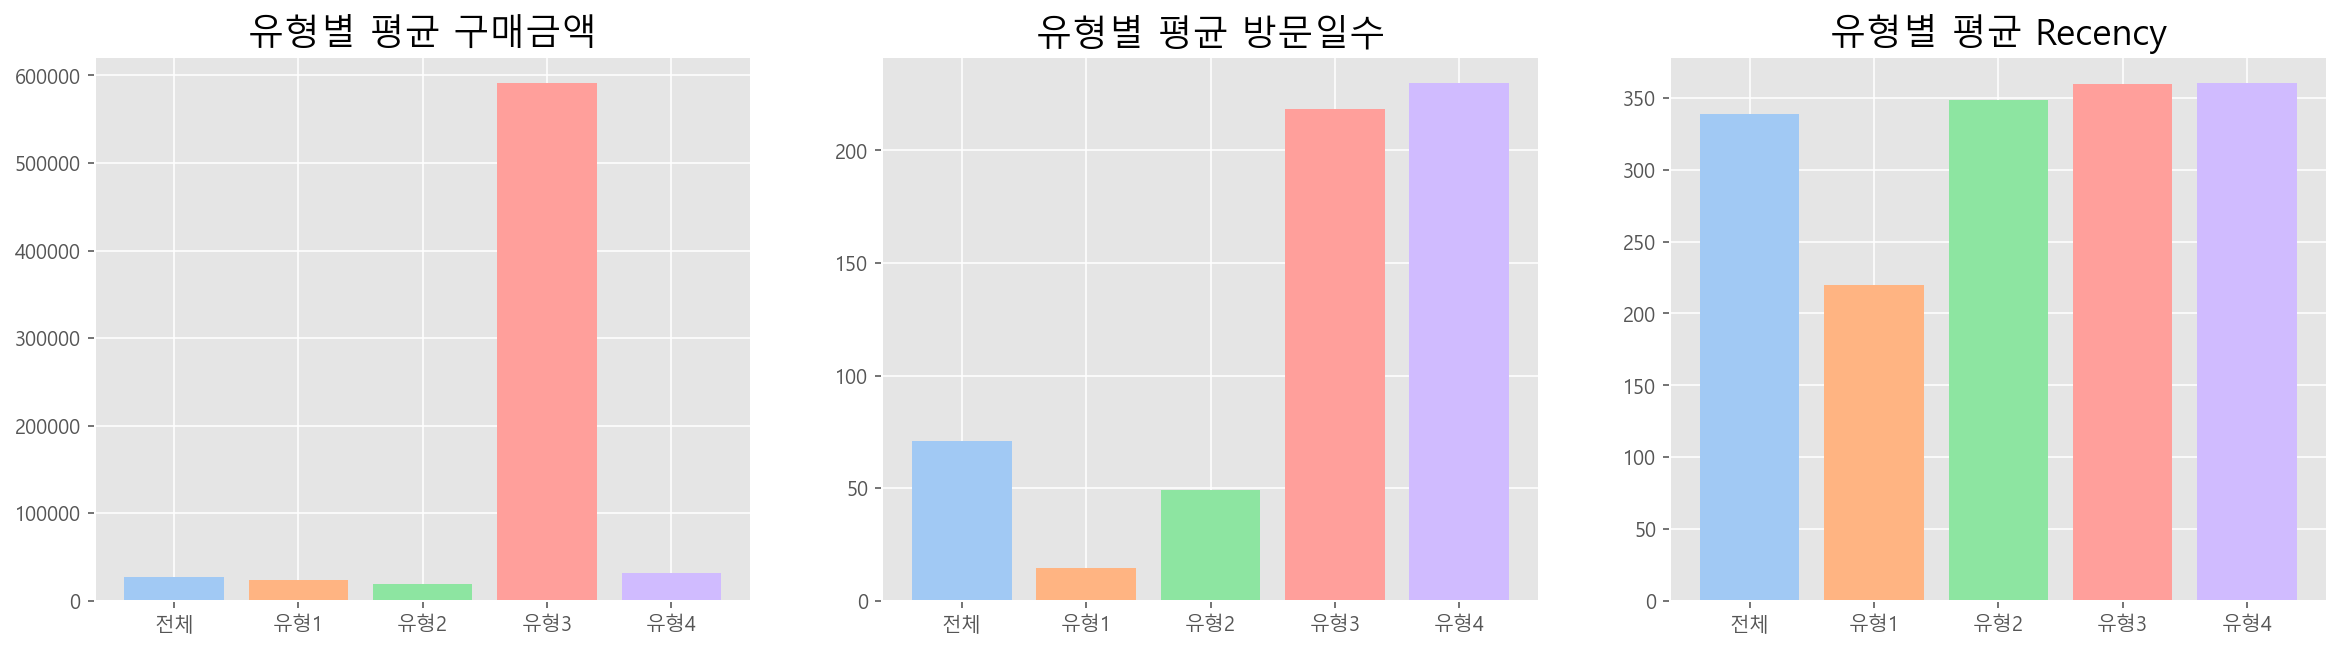

In [6]:
colors = sns.color_palette('pastel',5) # 색상 지정

plt.figure(figsize=(20,5))
# 구매금액
plt.subplot(1, 3, 1)
plt.bar(['전체', '유형1', '유형2', '유형3', '유형4'], [data['구매금액'].mean(), data.loc[data['고객번호'].isin(customer_0)]['구매금액'].mean(), data.loc[data['고객번호'].isin(customer_1)]['구매금액'].mean(),data.loc[data['고객번호'].isin(customer_2)]['구매금액'].mean(), 
                                             data.loc[data['고객번호'].isin(customer_3)]['구매금액'].mean()],color = colors)
plt.title('유형별 평균 구매금액', fontsize=18)
# 방문일수
plt.subplot(1, 3, 2)
plt.bar(['전체', '유형1', '유형2', '유형3', '유형4'],[df_rfm['Frequency'].mean(),df_rfm.loc[df_rfm['Customer_ID'].isin(customer_0)]['Frequency'].mean(),df_rfm.loc[df_rfm['Customer_ID'].isin(customer_1)]['Frequency'].mean(),
        df_rfm.loc[df_rfm['Customer_ID'].isin(customer_2)]['Frequency'].mean(), df_rfm.loc[df_rfm['Customer_ID'].isin(customer_3)]['Frequency'].mean()],color = colors)
plt.title('유형별 평균 방문일수', fontsize=18)

# Recency
plt.subplot(1, 3, 3)
plt.bar(['전체', '유형1', '유형2', '유형3', '유형4'], [df_rfm['Recency'].mean(),df_rfm.loc[df_rfm['Customer_ID'].isin(customer_0)]['Recency'].mean(),
        df_rfm.loc[df_rfm['Customer_ID'].isin(customer_1)]['Recency'].mean(),df_rfm.loc[df_rfm['Customer_ID'].isin(customer_2)]['Recency'].mean(), 
                                             df_rfm.loc[df_rfm['Customer_ID'].isin(customer_3)]['Recency'].mean()],color = colors)
plt.title('유형별 평균 Recency', fontsize=18)
plt.show()

-유형1, 그냥 한번 들러봄

- 유형1은 전체 데이터와 비교하였을 때, 평균 구매금액, 평균 방문일수, 평균 Recency모두가 낮은 것을 확인할 수 있다  
    - 즉, 4개의 유형 중 가장 충성도가 낮은 고객이라고 할 수 있다.  
    - 이후 마케팅 전략에서 해당 유형의 충성도를 높일 수 있는 전략을 짜면 좋을듯함  

-유형2, 다수  

- 유형2는 네개의 유형 중, 가장 속한 고객의 수가 높은 유형이다. 해당 그래프에서는 두드러지는 특징을 확인할 수 없다.  

-유형3, 충성고객VIP  

- 유형3은 네개의 유형 중, 속한 고객의 수가 가장 적은 유형이다. 해당 유형은 평균 구매금액이 다른 유형들에 비해 눈에 띄게 높음을 알 수 있다.  
- 또한, 평균 방문일수와 평균 Recency 또한 높음을 알 수 있다.  
    - 쉽게 말해 본 회사의 VIP라고 볼 수 있다.  
    - 이후 마케팅 전략에서 해당 유형은 이탈을 방지할 수 있는 전략을 수립하면 좋을듯함  

-유형4, 관심 고객  

- 유형4는 전체와 비교하였을 때, 평균 구매금액은 낮으나 평균 방문일수와 Recency점수가 높음을 알 수 있다.  
    - 즉, 구매력은 높지 않으나 본회사에 지속적인 관심을 가지고 있음을 알 수 있다.  
    - 이후 마케팅 전략에서 구매 금액을 지속적으로 향상시킬 수 있는 방안을 모색하면 좋을듯함

### 유형별 연령대 분포

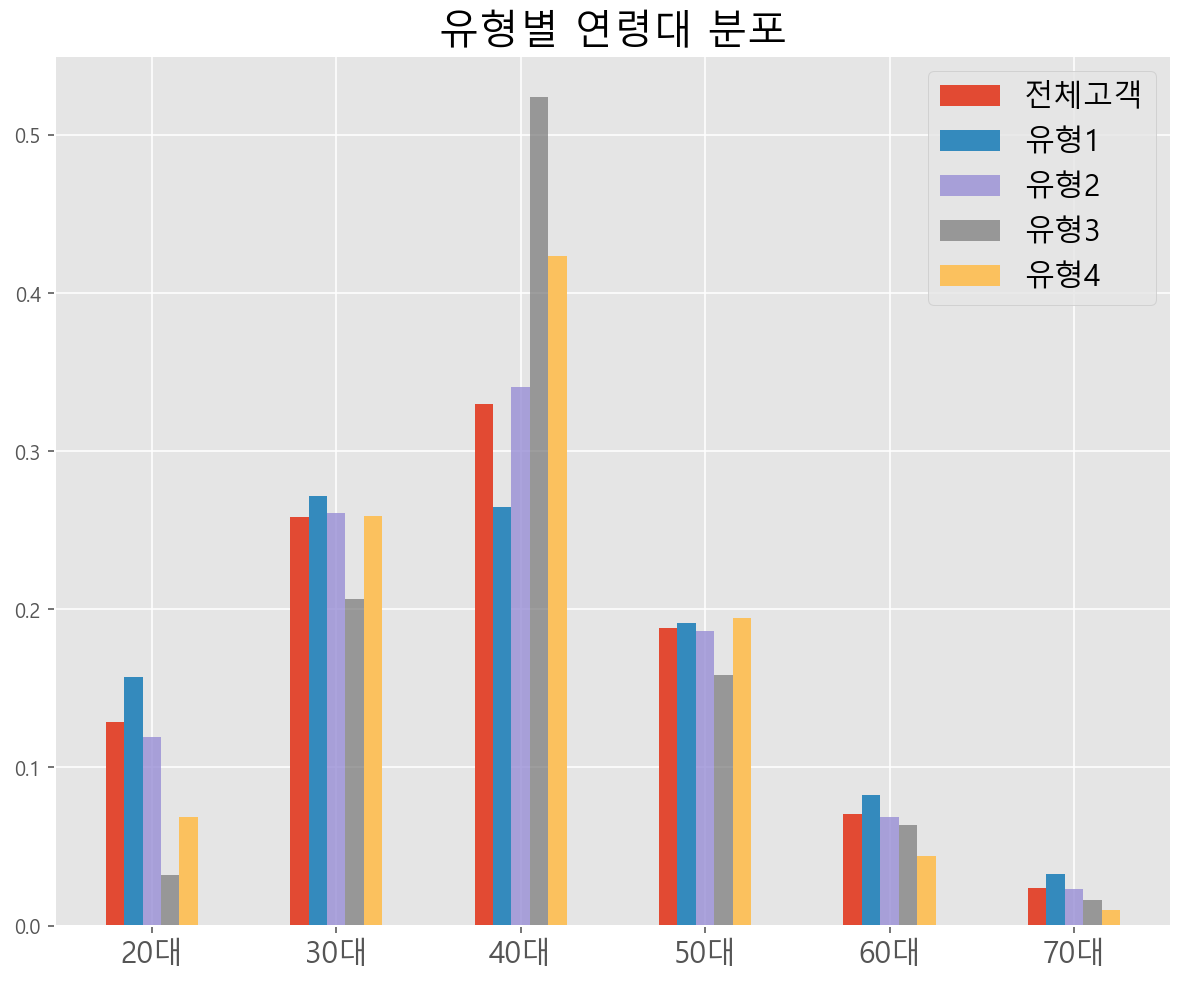

In [7]:
x = np.arange(6)

plt.figure(figsize=(10, 8))
# 전체
plt.bar(x-0.2, demo.groupby('연령대')['고객번호'].count().reset_index()['고객번호'] / demo.groupby('연령대')['고객번호'].count().sum(), 0.1, label='전체고객')
# 유형1
plt.bar(x-0.1,demo[demo['고객번호'].isin(customer_0)].groupby('연령대')['고객번호'].count().reset_index()['고객번호'] / \
               demo[demo['고객번호'].isin(customer_0)].groupby('연령대')['고객번호'].count().sum(), 0.1, label='유형1')
# 유형2
plt.bar(x,demo[demo['고객번호'].isin(customer_1)].groupby('연령대')['고객번호'].count().reset_index()['고객번호'] / \
               demo[demo['고객번호'].isin(customer_1)].groupby('연령대')['고객번호'].count().sum(), 0.1, label='유형2', alpha=0.8)
# 유형3
plt.bar(x+0.1,demo[demo['고객번호'].isin(customer_2)].groupby('연령대')['고객번호'].count().reset_index()['고객번호'] / \
               demo[demo['고객번호'].isin(customer_2)].groupby('연령대')['고객번호'].count().sum(), 0.1, label='유형3', alpha=0.7)

# 유형4
plt.bar(x+0.2,demo[demo['고객번호'].isin(customer_3)].groupby('연령대')['고객번호'].count().reset_index()['고객번호'] / \
               demo[demo['고객번호'].isin(customer_3)].groupby('연령대')['고객번호'].count().sum(), 0.1, label='유형4')

plt.xticks(x, ['20대', '30대', '40대', '50대', '60대', '70대'], fontsize = 15)
plt.legend(fontsize = 15)
plt.title('유형별 연령대 분포', fontsize=20)
plt.show()

### 각 유형별 평균 나이대

In [8]:
# 유형1
type1_age = demo[demo['고객번호'].isin(customer_0)]['연령대'].apply(lambda x:int(x[:2])).mean()
print(f'유형1의 평균 나이: {type1_age}')

유형1의 평균 나이: 38.680248007085915


In [9]:
# 유형2
type2_age = demo[demo['고객번호'].isin(customer_1)]['연령대'].apply(lambda x:int(x[:2])).mean()
print(f'유형2의 평균 나이: {type2_age}')

유형2의 평균 나이: 38.93996755002704


In [10]:
# 유형3
type3_age = demo[demo['고객번호'].isin(customer_2)]['연령대'].apply(lambda x:int(x[:2])).mean()
print(f'유형3의 평균 나이: {type3_age}')

유형3의 평균 나이: 40.63492063492063


In [11]:
# 유형4
type4_age = demo[demo['고객번호'].isin(customer_3)]['연령대'].apply(lambda x:int(x[:2])).mean()
print(f'유형4의 평균 나이: {type4_age}')

유형4의 평균 나이: 39.15822072072072


-유형1  

- 유형1의 경우 30,50,60,70의 경우는 전체 고객과 비슷한 경향을 보임.  
- 하지만 전체고객 대비 20대의 비율이 조금 높은 경향을 보이고, 40대의 비율은 적은 모습을 보인다.   
    - 주 연령층이라고 볼 수 있는 20-50대 중, 구매력이 가장 낮은 20대의 비율이 높고, 구매력이 강한 40대의 비율은 낮은 모습을 보임  

-유형2  

- 유형2의 경우 전체 고객과 비교하였을 때, 두드러지는 특징을 찾기는 힘들어보임  

-유형3  

- 유형3의 경우 전체 고객과 비교하여 보았을 때, 40대의 비율이 매우 높고, 20대의 비율은 매우 낮음을 볼 수 있다.  
    - 구매력이 가장 크다고 볼 수 있는 연령층인 40대의 비율이 가장 높고, 구매력이 비교적 낮은 20대의 비율이 적음을 알 수 있다.  

-유형4  

- 유형4의 경우 또한 유형3과 비슷한 모습을 보인다.  
    - 주 구성원은 비슷하나, 구매력에서 차이를 보이는 듯함  
    - 이후 분석에서 구매력이 낮은 요인을 분석하고, 구매력은 있으나 구매를 하지 않는 경우 마케팅을 통해 구매를 유도하여 유형3과 같이 VIP로 전환 가능할듯함

### 유형별 거주지 비교

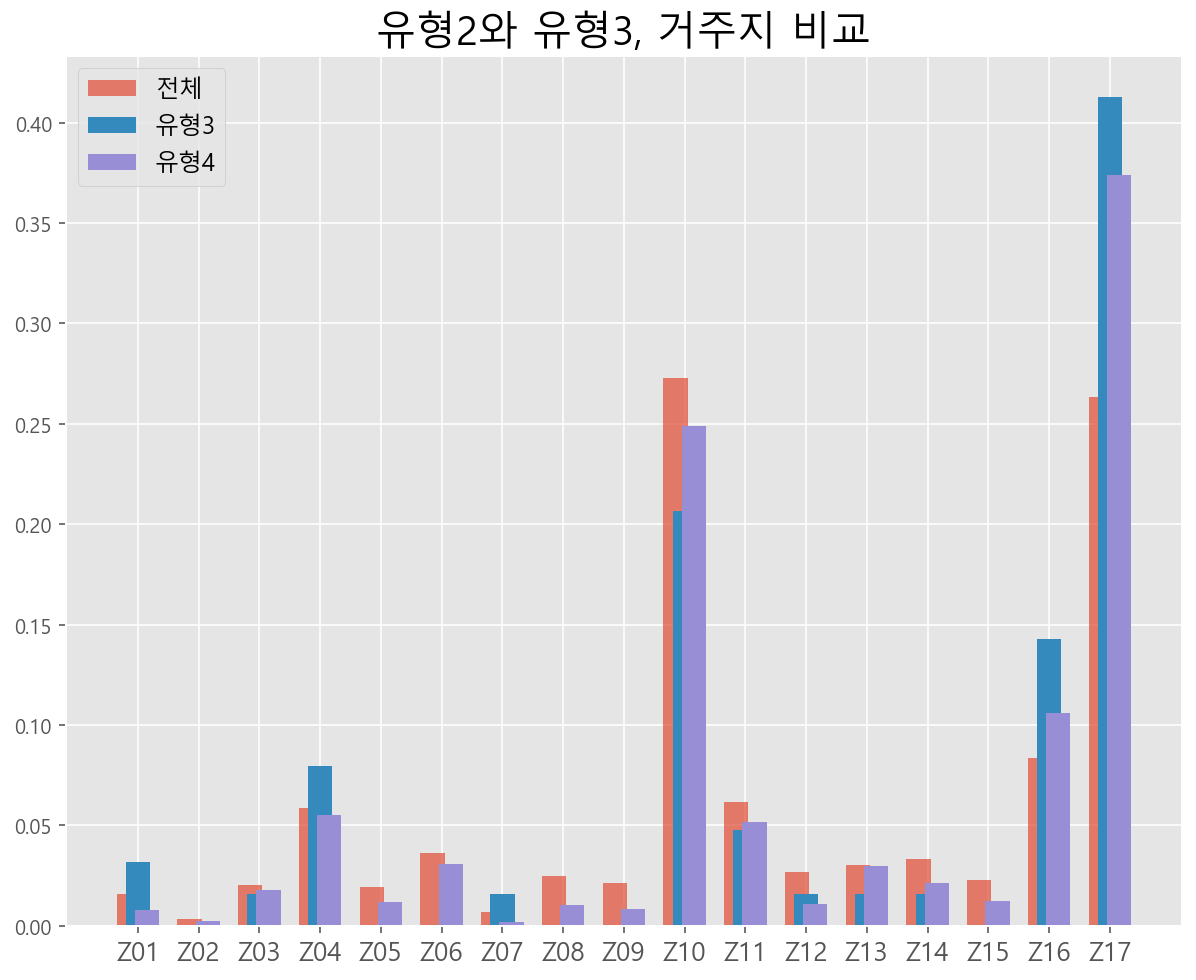

In [12]:
cust_2_resi = pd.concat([demo[demo['고객번호'].isin(customer_2)].groupby('거주지대분류코드')['고객번호'].count().reset_index(), 
           pd.DataFrame([['Z02', 0], ['Z05', 0], ['Z06', 0], ['Z08', 0], ['Z09', 0], ['Z15', 0]], 
           columns=['거주지대분류코드', '고객번호'])]).sort_values(by='거주지대분류코드').reset_index(drop=True)


plt.figure(figsize=(10, 8))
x = np.arange(len(cust_2_resi['거주지대분류코드']))
plt.bar(x-0.15, demo.groupby('거주지대분류코드')['고객번호'].count() /\
                demo.groupby('거주지대분류코드')['고객번호'].count().sum(), 0.4, label='전체', alpha=0.7)
plt.bar(x, cust_2_resi['고객번호'] / cust_2_resi['고객번호'].sum(), 0.4, label='유형3')
plt.bar(x+0.15, demo[demo['고객번호'].isin(customer_3)].groupby('거주지대분류코드')['고객번호'].count() /\
                demo[demo['고객번호'].isin(customer_3)].groupby('거주지대분류코드')['고객번호'].count().sum(), 0.4, label='유형4')

plt.xticks(x, cust_2_resi['거주지대분류코드'],fontsize = 13)
plt.legend(fontsize = 12)
plt.title('유형2와 유형3, 거주지 비교', fontsize = 20)
plt.show()

전체적으로  

- 유형1, 2, 4는 전체 고객과 사는 지역의 분포가 비슷함  
    - 전부 확인하였지만 그래프의 가독성을 위하여 위의 세 그룹만 시각화함  
- 유형3의 경우, 전체의 약 55-60%의 고객이 Z16, Z17지역에 거주 중임  
    - 해당 지역을 찾을 수 있다면, 해당 지역에 해당 유형 고객이 많은 이유를 도출해낼 수 있을듯함  
    - 확실한 결과는 아니지만 다른 깃헙 갱다녀온 결과 Z10:경기도, Z16:부산, Z17:서울임을 확인 -> 유형3의 데이터 수가 적어서 나타나는 현상일 수도 있음 주의필요

### 유형별 구매시간 파악

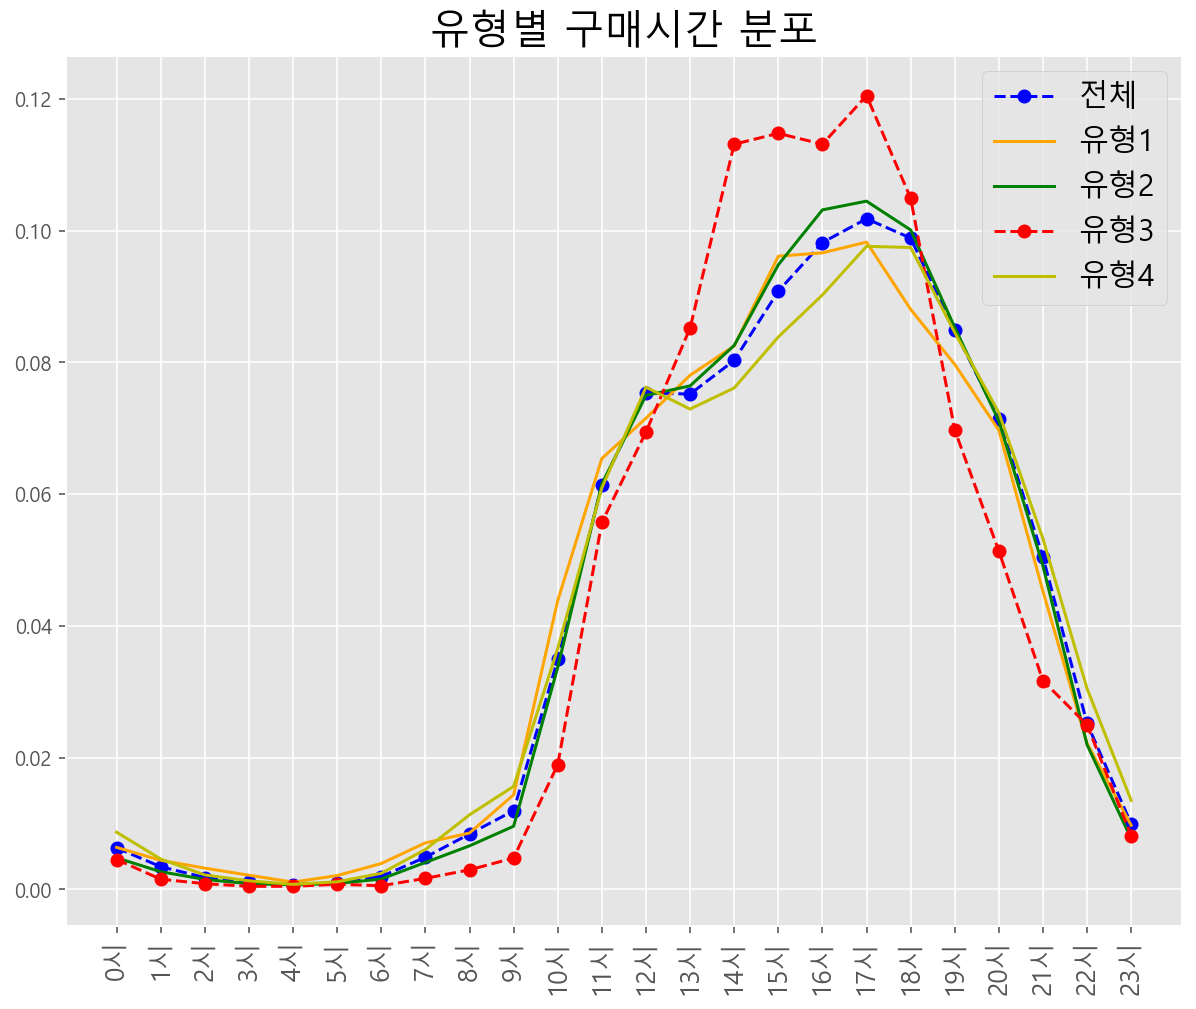

In [13]:
plt.figure(figsize=(10, 8))
x = np.arange(len(data['구매시간'].unique()))
plt.plot(data.groupby('구매시간')['고객번호'].count().reset_index()['구매시간'], 
         data.groupby('구매시간')['고객번호'].count().reset_index()['고객번호'] /\
         data.groupby('구매시간')['고객번호'].count().reset_index()['고객번호'].sum(), label='전체',linestyle='--',marker='o', c='b')
plt.plot(data[data['고객번호'].isin(customer_0)].groupby('구매시간')['고객번호'].count().reset_index()['구매시간'], 
         data[data['고객번호'].isin(customer_0)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'] /\
         data[data['고객번호'].isin(customer_0)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'].sum(), label='유형1', c='orange')
plt.plot(data[data['고객번호'].isin(customer_1)].groupby('구매시간')['고객번호'].count().reset_index()['구매시간'], 
         data[data['고객번호'].isin(customer_1)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'] /\
         data[data['고객번호'].isin(customer_1)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'].sum(), label='유형2',c='g')
plt.plot(data[data['고객번호'].isin(customer_2)].groupby('구매시간')['고객번호'].count().reset_index()['구매시간'], 
         data[data['고객번호'].isin(customer_2)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'] /\
         data[data['고객번호'].isin(customer_2)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'].sum(), label='유형3',linestyle='--',marker='o', c='r')
plt.plot(data[data['고객번호'].isin(customer_3)].groupby('구매시간')['고객번호'].count().reset_index()['구매시간'], 
         data[data['고객번호'].isin(customer_3)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'] /\
         data[data['고객번호'].isin(customer_3)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'].sum(), label='유형4', c='y')
plt.xticks(x, [f'{i}시' for i in range(24)],fontsize = 13)
plt.xticks(rotation=90) #x축 값 세로로 변경
plt.title('유형별 구매시간 분포', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

- 전체와 비교하였을 때, 다른 유형들은 별다른 특이점이 없는 반면 유형3의 경우 오후 2시에 구매율이 높은 것을 확인할 수 있다.

### 유형별 채널

In [14]:
# 전체
data.groupby('채널구분')['고객번호'].count() / data.groupby('채널구분')['고객번호'].count().sum()

채널구분
1    0.87068
2    0.12932
Name: 고객번호, dtype: float64

In [15]:
# 유형1
data[data['고객번호'].isin(customer_0)].groupby('채널구분')['고객번호'].count() / data[data['고객번호'].isin(customer_0)].groupby('채널구분')['고객번호'].count().sum()

채널구분
1    0.879881
2    0.120119
Name: 고객번호, dtype: float64

In [16]:
# 유형2
data[data['고객번호'].isin(customer_1)].groupby('채널구분')['고객번호'].count() / data[data['고객번호'].isin(customer_1)].groupby('채널구분')['고객번호'].count().sum()

채널구분
1    0.903877
2    0.096123
Name: 고객번호, dtype: float64

In [17]:
# 유형3
data[data['고객번호'].isin(customer_2)].groupby('채널구분')['고객번호'].count() / data[data['고객번호'].isin(customer_2)].groupby('채널구분')['고객번호'].count().sum()

채널구분
1    0.916264
2    0.083736
Name: 고객번호, dtype: float64

In [18]:
# 유형4
data[data['고객번호'].isin(customer_3)].groupby('채널구분')['고객번호'].count() / data[data['고객번호'].isin(customer_3)].groupby('채널구분')['고객번호'].count().sum()

채널구분
1    0.817577
2    0.182423
Name: 고객번호, dtype: float64

### 유형별 Lpay

- Lpay와 상품을 동시에 결제

In [19]:
unuse_Lpay = demo[demo['고객번호'].isin(set(data[data['타입'] == 'Lpay']['고객번호'])) == False]['고객번호']
useLpay = demo[demo['고객번호'].isin(set(data[data['타입'] == 'Lpay']['고객번호']))]['고객번호']

In [20]:
# Lpay와 상품 구매를 동시에 한 영수증은 없음 ( ex) 결제 금액이 40500일 경우 500만 포인트로 결제하는 등의 경우는 없음 )
len(data[data['타입'] != 'Lpay'][data[data['타입'] != 'Lpay']['영수증번호'].isin(set(data[data['타입'] == 'Lpay']['영수증번호']))])

0

- Lpay이용자의 비율

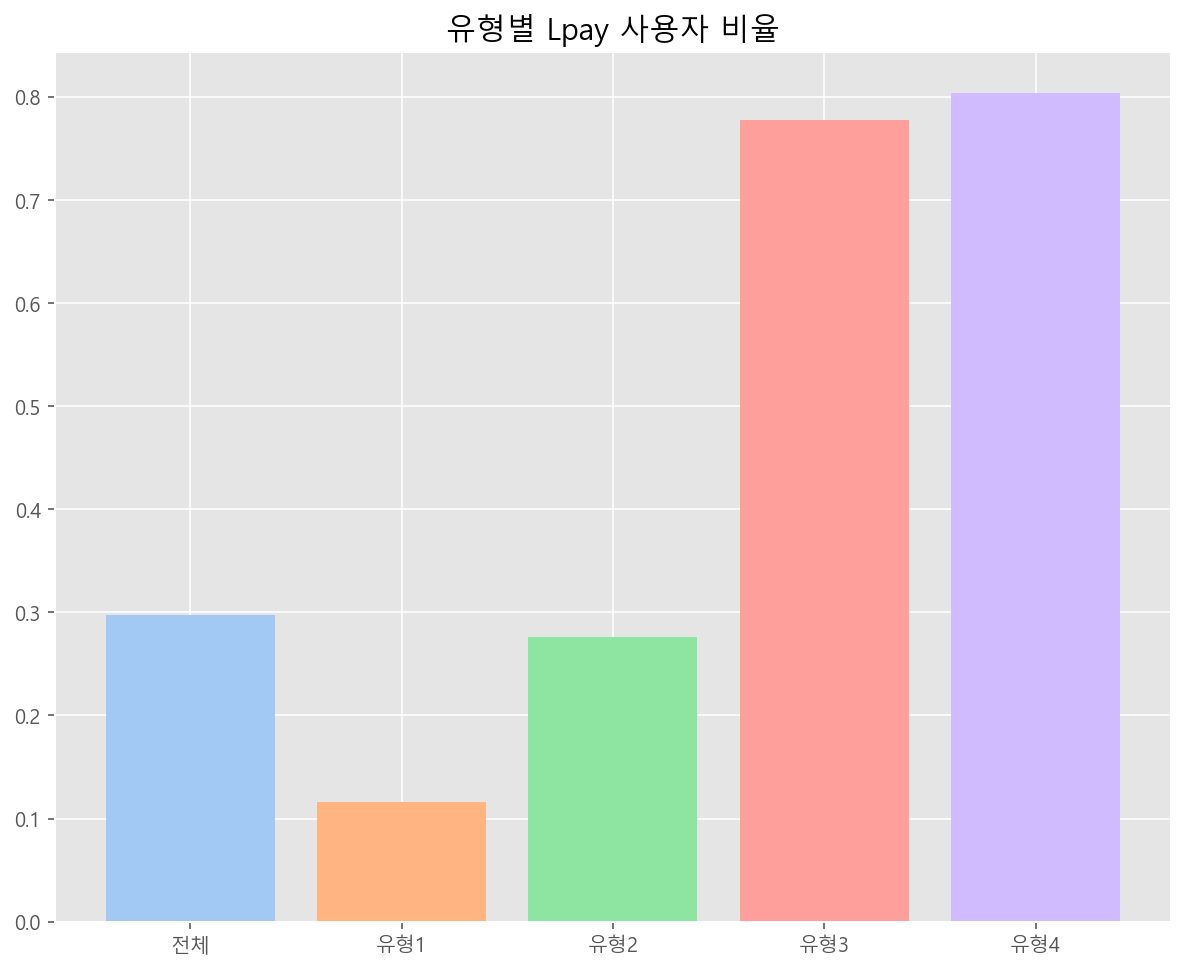

In [21]:
## 전체
lpay_ratio = [(len(useLpay) / len(demo)),  (len(customer_0[customer_0.isin(useLpay)]) / len(customer_0)), (len(customer_1[customer_1.isin(useLpay)]) / len(customer_1)),
            (len(customer_2[customer_2.isin(useLpay)]) / len(customer_2)), (len(customer_3[customer_3.isin(useLpay)]) / len(customer_3))]

colors = sns.color_palette('pastel',5)
plt.figure(figsize=(10, 8))
plt.bar(['전체', '유형1', '유형2', '유형3', '유형4'], lpay_ratio, color = colors)
plt.title('유형별 Lpay 사용자 비율', fontsize=15)
plt.show()

- 전체와 비교해 보았을 때, 유형1의 경우 Lpay이용자의 수가 매우 적고, 유형3,4의 경우 이용률이 높음을 알 수 있음.   
- 특히,유형3의 이용률은 많이 높음 -> 위의 시각화 결과와 맥이 통하는 모습을 보임

- Lpay 이용자와 미이용자의 평균금액 비교

In [22]:
lpay_x = [
          data[data['고객번호'].isin(unuse_Lpay)]['구매금액'].mean(),
          data[data['고객번호'].isin(customer_0[customer_0.isin(useLpay)==False])]['구매금액'].mean(),
          data[data['고객번호'].isin(customer_1[customer_1.isin(useLpay)==False])]['구매금액'].mean(), 
          data[data['고객번호'].isin(customer_2[customer_2.isin(useLpay)==False])]['구매금액'].mean(),
          data[data['고객번호'].isin(customer_3[customer_3.isin(useLpay)==False])]['구매금액'].mean()
         ]
lpay_o = [data[data['고객번호'].isin(useLpay)]['구매금액'].mean(), data[data['고객번호'].isin(customer_0[customer_0.isin(useLpay)])]['구매금액'].mean(),
          data[data['고객번호'].isin(customer_1[customer_1.isin(useLpay)])]['구매금액'].mean(), data[data['고객번호'].isin(customer_2[customer_2.isin(useLpay)])]['구매금액'].mean(),
          data[data['고객번호'].isin(customer_3[customer_3.isin(useLpay)])]['구매금액'].mean()]

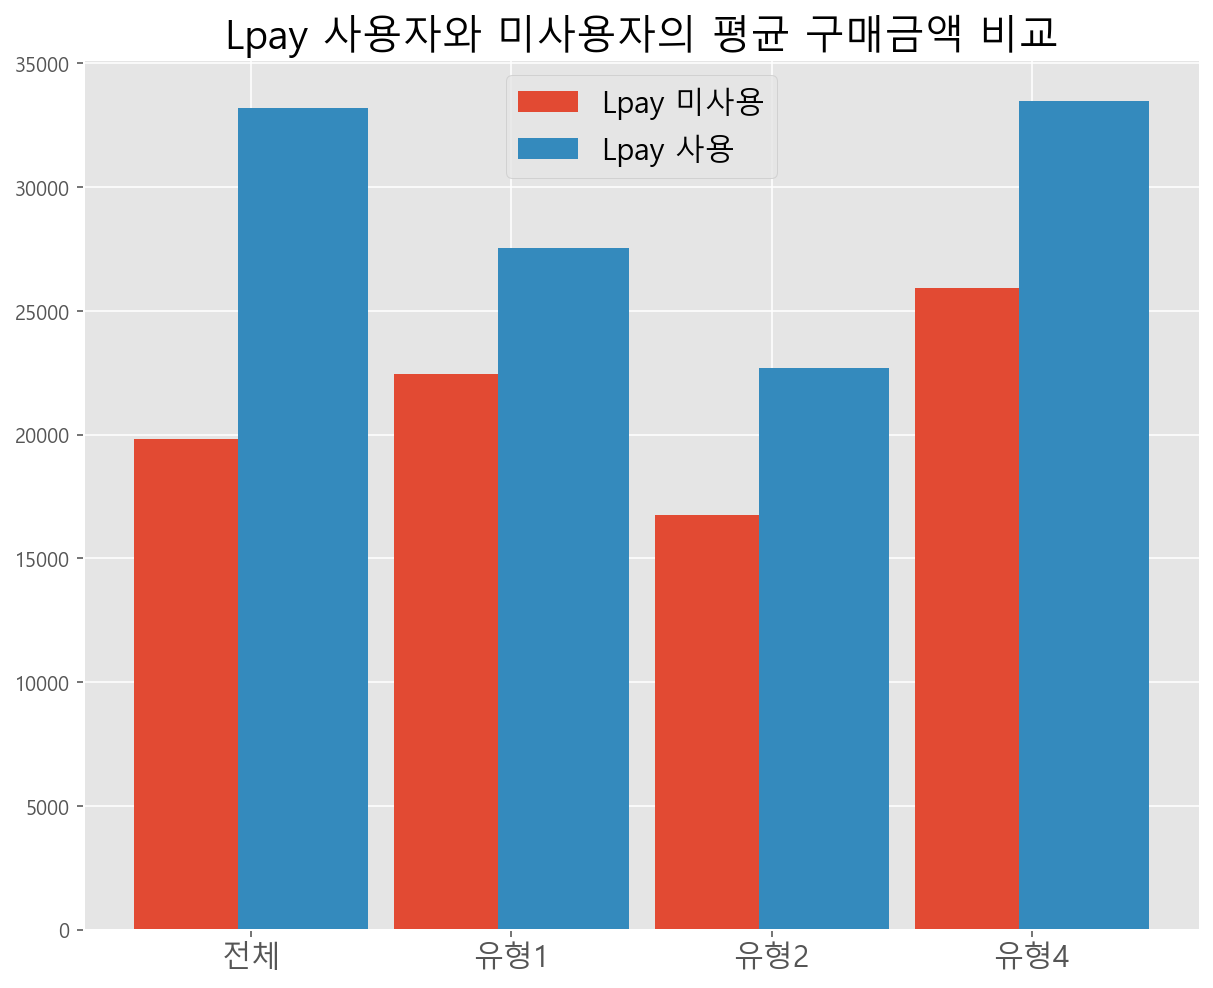

In [23]:
# 유형 3의 경우 Lpay를 사용하지 않는 고객의 평균 구매비용이 더 높음
x = np.arange(4)

plt.figure(figsize=(10, 8))
plt.bar(x-0.2, [lpay_x[0], lpay_x[1], lpay_x[2], lpay_x[4]], 0.5, label='Lpay 미사용')
plt.bar(x+0.2, [lpay_o[0], lpay_o[1], lpay_o[2], lpay_o[4]], 0.5, label='Lpay 사용')
plt.xticks(x, ['전체', '유형1', '유형2', '유형4'], fontsize = 15)
plt.legend(fontsize = 15)
plt.title('Lpay 사용자와 미사용자의 평균 구매금액 비교', fontsize=20)
plt.show()

- 유형3을 제외한 나머지 유형들은 Lpay를 사용하는 고객의 평균 구매금액이 더 높음을 알 수 있다.

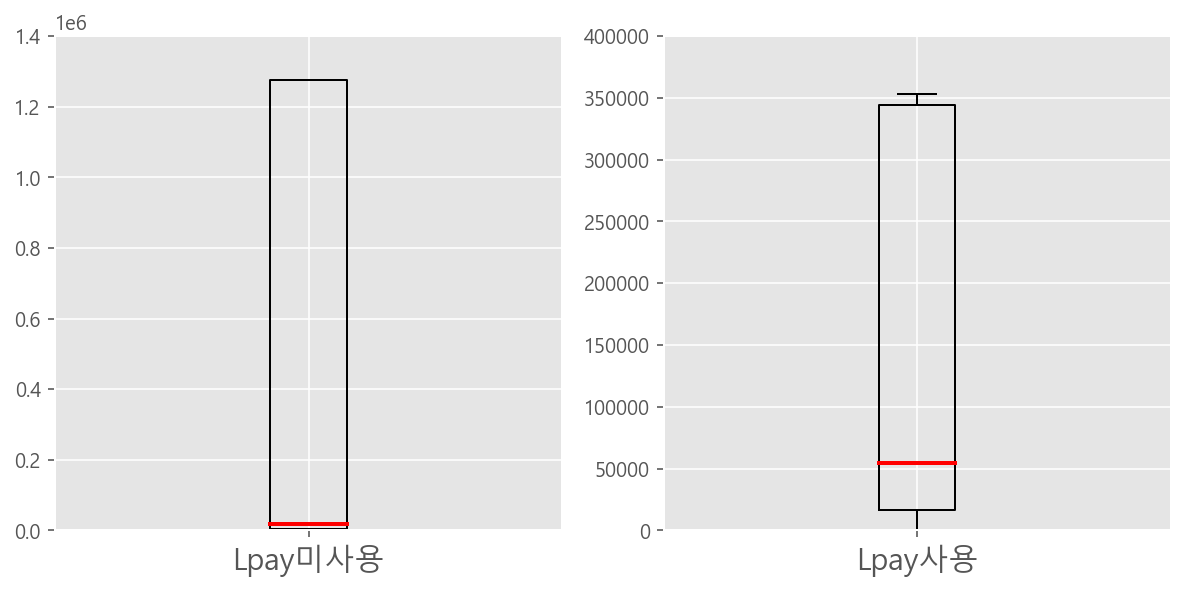

In [24]:
plt.figure(figsize=(10,10))
# 엘페이 미사용
plt.subplot(2, 2, 1)
plt.boxplot(data[data['타입'] != 'Lpay']['구매금액'].describe(), medianprops=dict(color='r', linewidth=2))
plt.xticks([1],['Lpay미사용'], fontsize=15)
plt.ylim([0, 1400000])
# 엘페이 사용
plt.subplot(2, 2, 2)
plt.boxplot(data[data['타입'] == 'Lpay']['구매금액'].describe(), medianprops=dict(color='r', linewidth=2))
plt.xticks([1],['Lpay사용'], fontsize=15)
plt.ylim([0, 400000])
plt.show()

- 하지만 이는 단순히 Lpay로 결제하였을 때의 금액이 평소 구매금액보다 큰 경우인듯함  
- 위의 사분위수를 보면 단순 구매액보다 Lpay구매액이 더 높음  

-> 정리해보면, 유형1,2,4의 경우 Lpay로 결제하는 금액이 평소 결제하는 금액보다 높음을 알 수 있음  
   - 이후 분석 진행시 Lpay를 더 많이 사용하게 할 방법을 모색한다면 구매금액 측면에서 회사에 도움이 되는 결과를 얻을 수 있으리라 생각함

### 가장 많이 구매한 품목 확인

- 대, 중, 소분류 모두 확인해 보았으나 유형별 특징을 가장 잘 나타내는 중분류명으로 진행

In [25]:
most_buy = data.groupby('고객번호')['중분류명'].apply(list).apply(lambda x:max(x, key = x.count)).reset_index()

- wordcloud로 확인

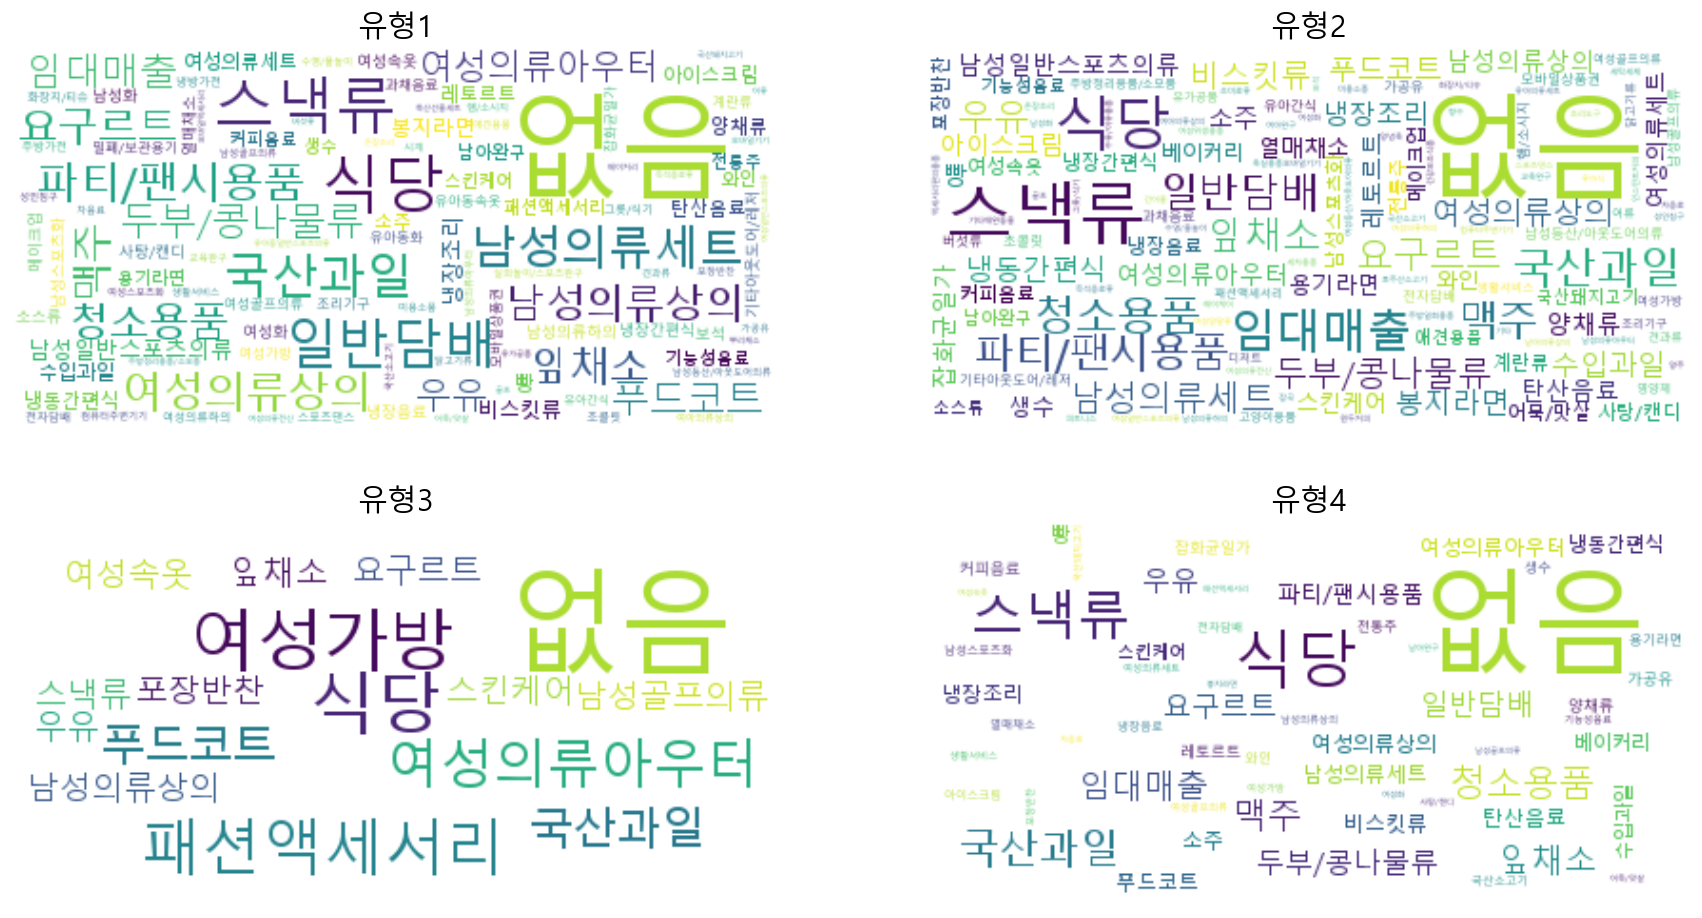

In [115]:
fontpath = 'C:/Windows/Fonts/malgun.ttf'

wordcloud_0 = WordCloud(
                      font_path = fontpath,
                      background_color='white',
                      random_state = 20, 
                      max_words = 200).generate_from_frequencies(Counter(most_buy[most_buy['고객번호'].isin(customer_0)]['중분류명'].dropna()))
wordcloud_1 = WordCloud(
                      font_path = fontpath, 
                      background_color='white',
                      random_state = 20, 
                      max_words = 200).generate_from_frequencies(Counter(most_buy[most_buy['고객번호'].isin(customer_1)]['중분류명'].dropna()))
wordcloud_2 = WordCloud(
                      font_path = fontpath, 
                      background_color='white',
                      random_state = 20, 
                      max_words = 200).generate_from_frequencies(Counter(most_buy[most_buy['고객번호'].isin(customer_2)]['중분류명'].dropna()))
wordcloud_3 = WordCloud(
                      font_path = fontpath, 
                      background_color='white',
                      random_state = 20, 
                      max_words = 200).generate_from_frequencies(Counter(most_buy[most_buy['고객번호'].isin(customer_3)]['중분류명'].dropna()))



plt.figure(figsize = (15, 8))
# 유형1
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_0, interpolation = "bilinear")
plt.axis("off")
plt.title('유형1', fontsize=15)
# 유형2
plt.subplot(2, 2, 2)
plt.imshow(wordcloud_1, interpolation = "bilinear")
plt.axis("off")
plt.title('유형2', fontsize=15)
# 유형3
plt.subplot(2, 2, 3)
plt.imshow(wordcloud_2, interpolation = "bilinear")
plt.axis("off")
plt.title('유형3', fontsize=15)
# 유형4
plt.subplot(2, 2, 4)
plt.imshow(wordcloud_3, interpolation = "bilinear")
plt.axis("off")
plt.title('유형4', fontsize=15)
plt.show()

- 유형1,  

- 지난 RFM시각화에서 '주방가전'  

- 유형2,  

- 보편적으로 많이 나타나는 품목들을 제외하고, 해당 유형의 고객들은 '임대매출'이 많이 나타남.  
- 아래에서 '임대매출'에 대한 분석을 진행함.  
    - '그린카'와 같은 자동차 임대업일 확률이 높음  
    - 해당 품목을 많이 사는 고객들로 이루어져있기 때문에 이에 관한 마케팅을 진행하면 좋을듯함  
    - 하지만, '임대매출'을 구매한 고객이 아닌 고객도 해당 유형에 포함돼 있기 때문에 이들에 대한 고려도 필요할듯함  

- 유형3,  

- 계속되는 시각화 결과에서 말해주듯, 해당 유형은 VIP.  
    - 구매 품목 또한 '명품'으로 줄여서 생각해도 될 듯함  

- 유형4,  

- 한마디로 '주부'라고 볼 수 있는 품목들을 많이 구매함  
    - 이전의 RFM시각화 결과를 바탕으로 확인한 결과 해당 유형의 고객들은 구매금액은 낮지만 충성도는 매우 높은 유형의 고객으로 분류 가능

- 임대매출

In [30]:
# 유통사는 A01혹은 A02
data[data['중분류명'] =='임대매출'].groupby('제휴사').count()['고객번호']

제휴사
A01    33417
A02       77
Name: 고객번호, dtype: int64

In [31]:
# 상품 코드는 PD0288로 한개
data[data['중분류명'] =='임대매출'].groupby('상품코드').count()['고객번호']

상품코드
PD0288    33494
Name: 고객번호, dtype: int64

In [32]:
# 구매금액은 보통 3만원~4만원 정도
data[data['중분류명'] =='임대매출']['구매금액'].describe()

count    3.349400e+04
mean     3.675424e+04
std      8.263915e+04
min      1.000000e+01
25%      1.000000e+04
50%      2.279000e+04
75%      4.070000e+04
max      1.000000e+07
Name: 구매금액, dtype: float64

In [33]:
df_cluster[df_cluster['제휴사'] == 'A01']['대분류명'].unique()

array(['남성의류', '없음', '조리식품', '구기/필드스포츠', '완구', '패션잡화', '테넌트/음식점', '여성의류',
       '유아동의류', '스포츠패션', '식기/조리기구', '헬스/피트니스', '수산물', '아웃도어/레저', '주방잡화',
       '유아식품', '시즌스포츠', '과일', '음료', '채소', '침구/수예', '대용식', '속옷/양말/홈웨어',
       '과자', '조미료', '주류', '생활/렌탈서비스', '서적/음반/악기', '냉동식품', '냉장식품', '상품권',
       '화장품/뷰티케어', '축산물', '자동차용품', '건강식품', '영상/음향가전', '문구/사무용품', '커피/차',
       '생활/주방가전', '가구', '세제/위생', '병통조림', '원예/애완', '여행/레저서비스', '건강용품',
       '냉장/세탁가전', '퍼스널케어', '양곡', '계절가전', '유제품', '컴퓨터', '모바일',
       '청소/세탁/욕실용품', '인테리어/조명', '건해산물', '출산/육아용품', '공구/안전용품', '기타(비상품)',
       '담배'], dtype=object)

In [34]:
# 10번 이상 이용한 고객은 적음 -> 일회성이 짙은 렌탈 품목일 가능성 높음
data[data['중분류명'] =='임대매출'].groupby('고객번호').count().sort_values('영수증번호', ascending = False)['영수증번호'].describe()

count    3658.000000
mean        9.156370
std        13.843579
min         1.000000
25%         2.000000
50%         4.000000
75%        11.000000
max       146.000000
Name: 영수증번호, dtype: float64

In [35]:
# 예시로 살펴본 결과 구매 금액과 일자가 일정하지 않은 것을 알 수 있음
data[(data['중분류명'] =='임대매출') & (data['고객번호'] == 'M438405999')][['고객번호', '성별', '연령대', '구매일자', '구매시간', '날짜', '구매금액', '거주지대분류코드', '점포대분류코드']]

,고객번호,성별,연령대,구매일자,구매시간,날짜,구매금액,거주지대분류코드,점포대분류코드
49749,M438405999,여성,30대,20210204,11,2021-02-04,6600,Z10,Z10
52543,M438405999,여성,30대,20210205,18,2021-02-05,210000,Z10,Z10
52595,M438405999,여성,30대,20210205,18,2021-02-05,4000,Z10,Z10
54023,M438405999,여성,30대,20210206,15,2021-02-06,22000,Z10,Z10
59915,M438405999,여성,30대,20210209,14,2021-02-09,6000,Z10,Z10
...,...,...,...,...,...,...,...,...,...
653752,M438405999,여성,30대,20211224,12,2021-12-24,31000,Z10,Z10
653770,M438405999,여성,30대,20211224,12,2021-12-24,12000,Z10,Z10
662183,M438405999,여성,30대,20211227,14,2021-12-27,36000,Z10,Z10
667834,M438405999,여성,30대,20211231,11,2021-12-31,30000,Z10,Z10


- 부드러운 곡선으로 확인

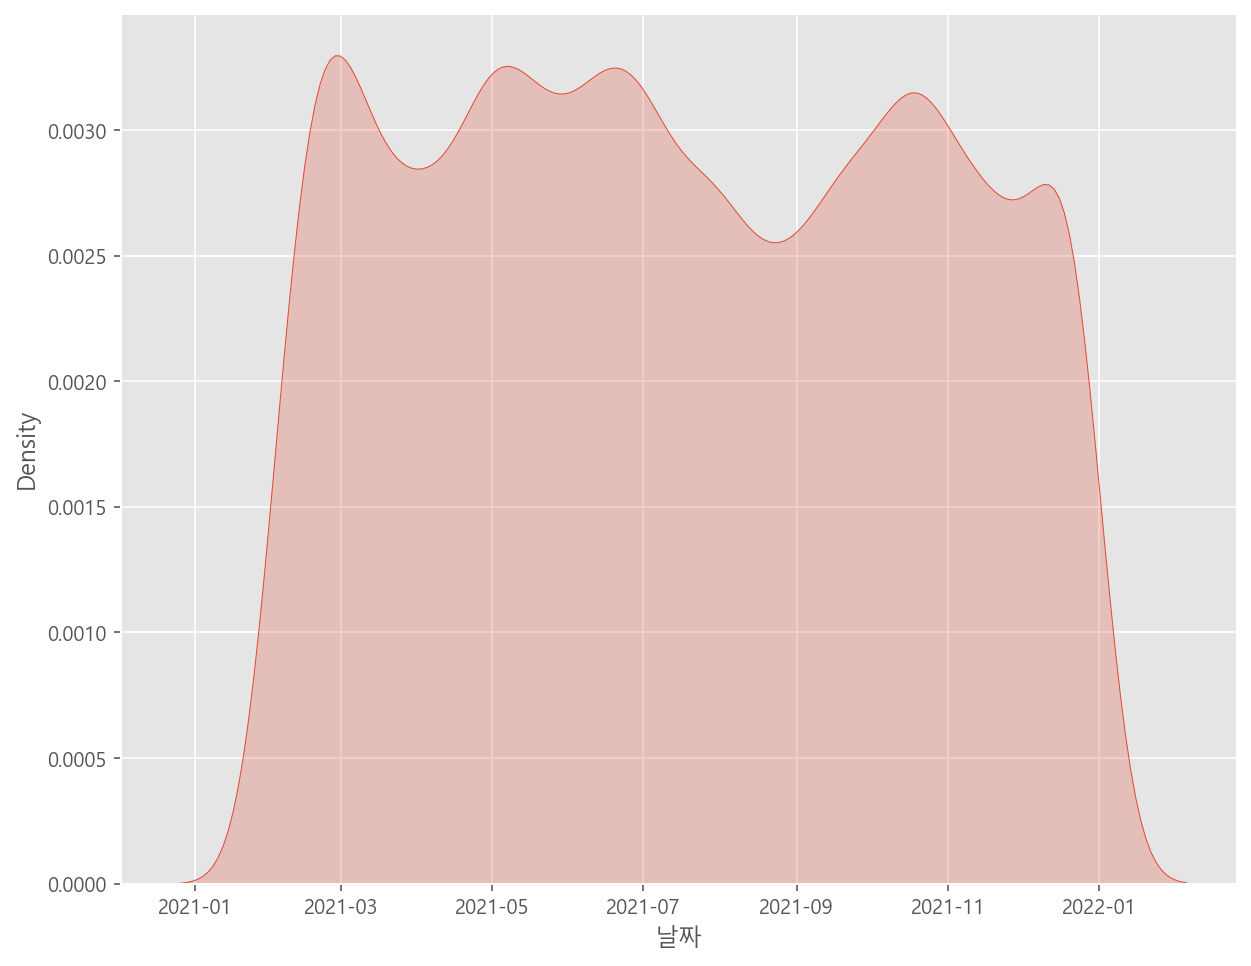

In [43]:
# 이용자의 날짜 분포를 확인해봄
df_cluster_copy = df_cluster.copy()
df_cluster_copy['날짜'] = pd.to_datetime(df_cluster_copy['날짜'])
fig = plt.figure(figsize = (10,8))
sns.kdeplot(df_cluster_copy[df_cluster_copy['중분류명'] == '임대매출']['날짜'], shade = True)
plt.show()

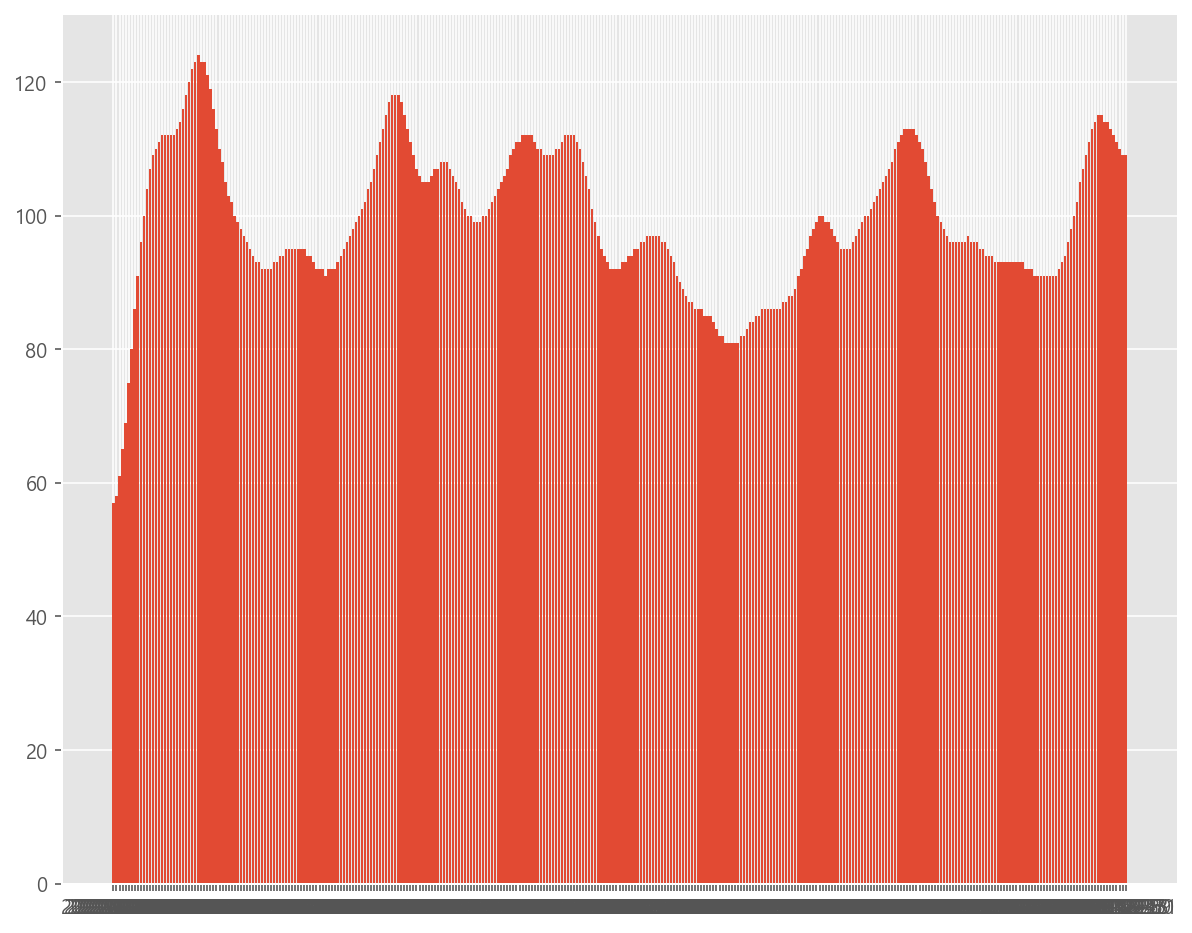

In [45]:
fig = plt.figure(figsize = (10,8))

plt.bar(df_cluster[df_cluster['중분류명'] == '임대매출'].groupby('날짜').count().reset_index()['날짜'], gaussian_filter1d(df_cluster[df_cluster['중분류명'] == '임대매출'].groupby('날짜').count().reset_index()['고객번호'], sigma=5))
plt.show()

 - 8월, 12월은 이용자 수가 적어지는 모습을 보임

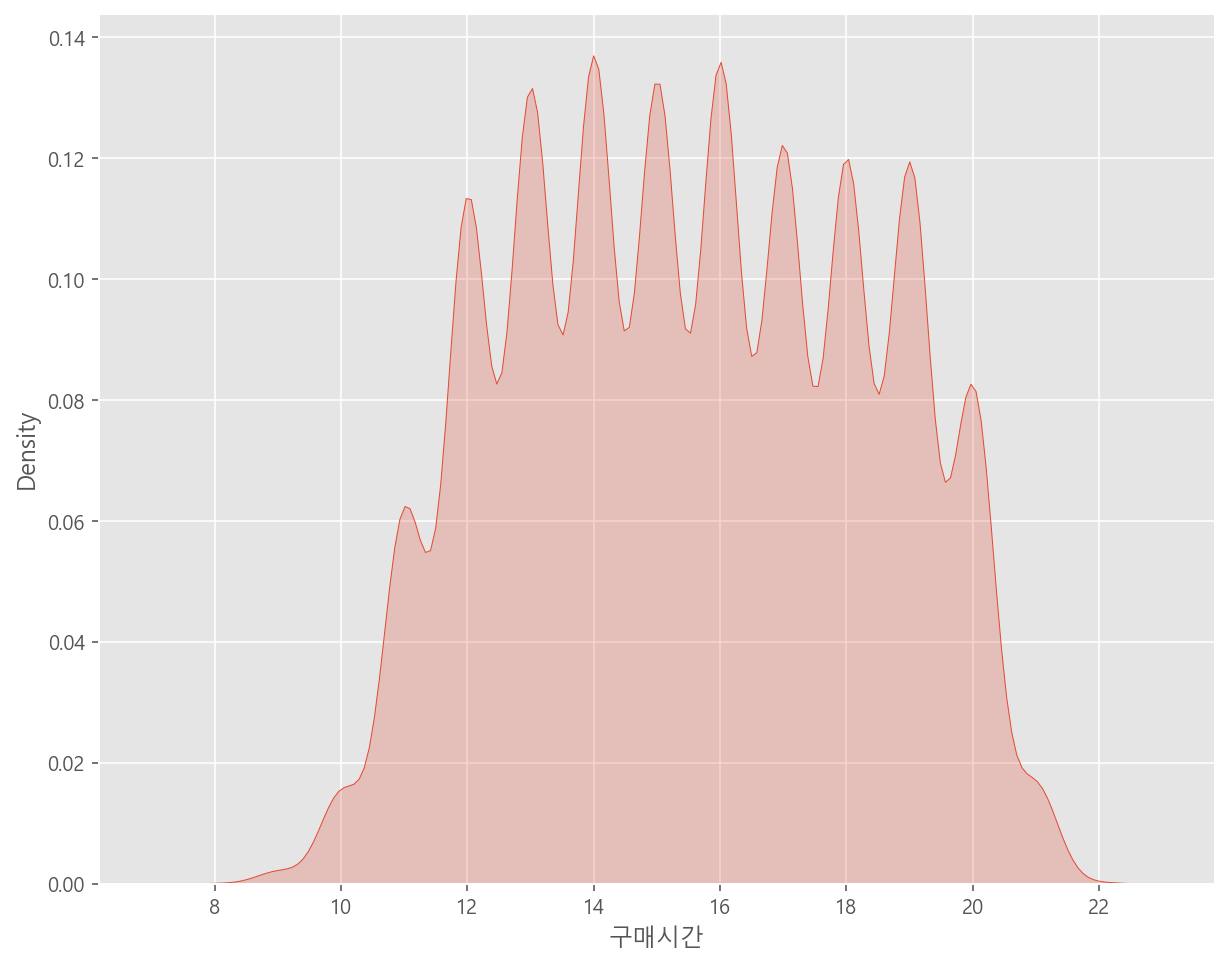

In [46]:
# 구매시간 확인
fig = plt.figure(figsize = (10,8))
sns.kdeplot(df_cluster[df_cluster['중분류명'] == '임대매출']['구매시간'],shade = True)
plt.show()

- 구매시간이 10시 ~ 8시 사이에 몰려있음  
- 확실하지는 않지만 그린카, 롯데 렌터카, 숙박 등의 임대업이 아닐까 예상  
- but, 숙박비가 숙박이라고 쳤을때, 가격 분포가 너무 쌈  
- 그렇다면 높은 확률로 자동차, 롯데 렌탈 등 임대업일 확률이 높지 않을까 생각  
- 이후 한달주기로 동일한 금액이 결제된다면 롯데 렌탈일 확률이 높음   
    -> 구매금액과 주기가 일정하지 않은 것으로 보아 아닌듯함  
- 롯데월드와 비슷한 공간 대여가 아닐까 생각이 듬

### 유형1과 유형2의 특징을 잡아보자

- 온라인, 오프라인 이용 여부를 파이차트를 통해 확인

In [47]:
ch = data.groupby('고객번호')['채널구분'].apply(list).reset_index()

In [48]:
# 온라인 오프라인 이용 여부를 세가지로 나누어 확인
def div_ch(x):
    if set(x) == {1}: # 오프라인만 이용하는 경우
        return '오프라인'
    elif set(x) == {2}: # 온라인만 이용
        return '온라인'
    else: # 둘다이용
        return '둘다이용'

# 이용채널과 이용 횟수를 구해줌
ch['이용채널'] = ch['채널구분'].apply(div_ch)
ch['이용횟수'] = ch['채널구분'].apply(lambda x:len(x))

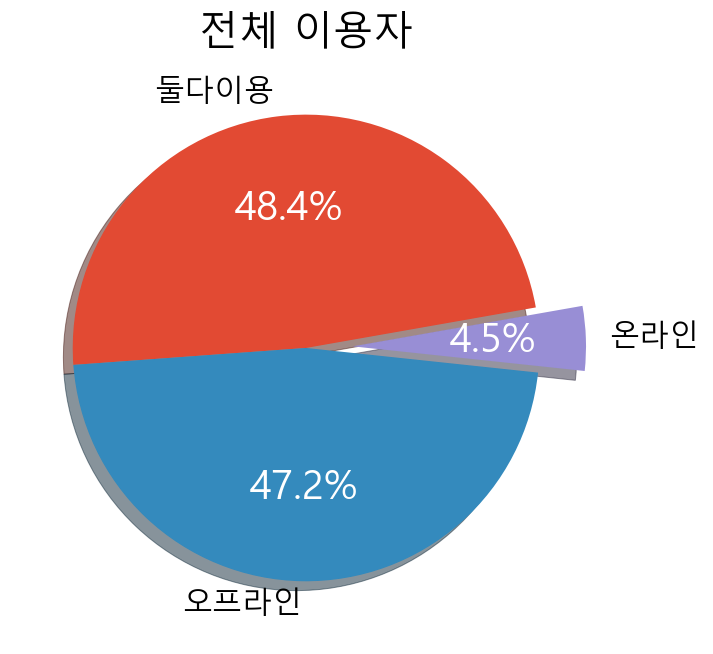

In [49]:
plt.figure(figsize=(5,5))
patches, texts, autotexts = plt.pie(
    ch.groupby('이용채널').count().reset_index()['고객번호'],
    labels = ch.groupby('이용채널').count().reset_index()['이용채널'],
    labeldistance=1.1,## label이 파이로부터 얼마나 떨어지는가, 1일경우 딱 붙어있음. 
    explode=[0, 0, 0.2], ##pie가 튀어나오는지 정해줌  
    startangle=10,## 어디에서 시작할지, 정해줌  
    shadow=True, ##그림자 
    autopct='%1.1f%%') ## pi 위에 표시될 글자 형태, 또한 알아서 %로 변환해서 알려줌 
plt.title('전체 이용자', size = 20)
for t in autotexts:
    t.set_color("white")
    t.set_fontsize(20)
    
for t in texts:
    t.set_fontsize(15)

plt.tight_layout()
plt.show()

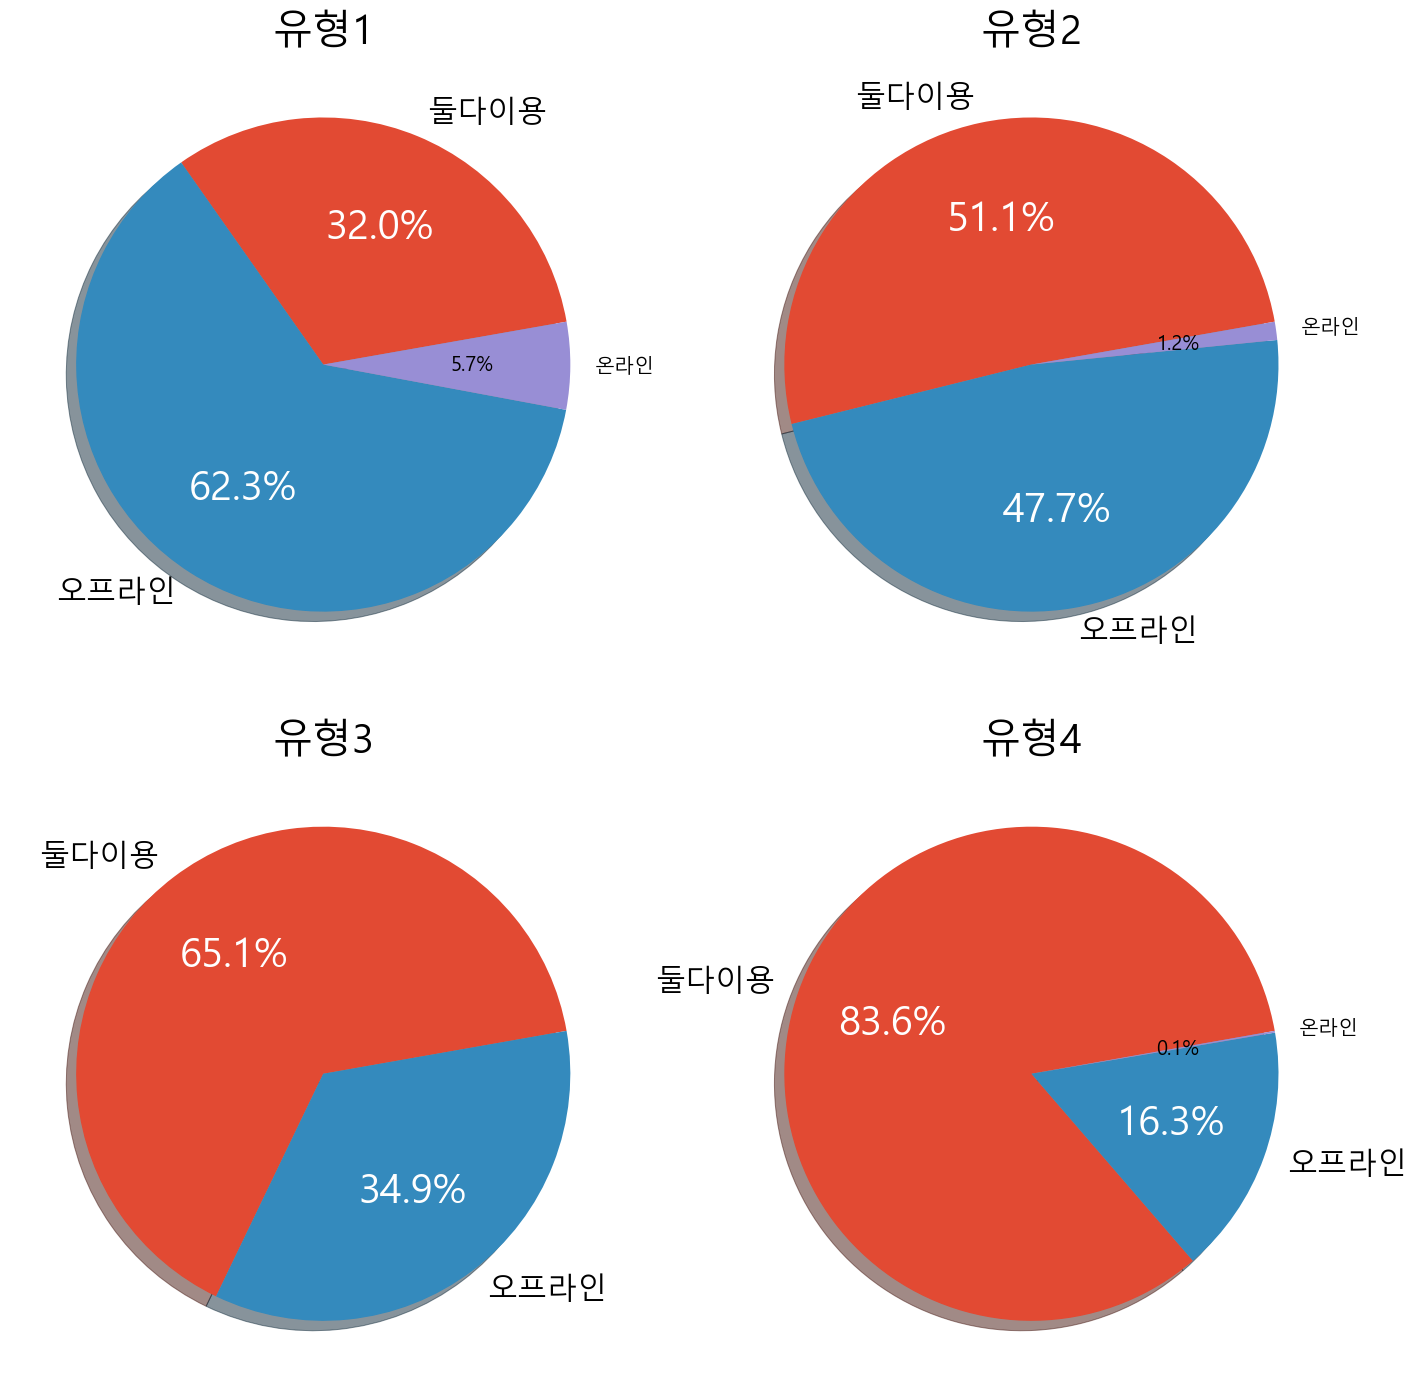

In [50]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
patches_0, texts_0, autotexts_0 = plt.pie(
    ch[ch['고객번호'].isin(customer_0)].groupby('이용채널').count().reset_index()['고객번호'],
    labels = ch[ch['고객번호'].isin(customer_0)].groupby('이용채널').count().reset_index()['이용채널'],
    labeldistance=1.1,## label이 파이로부터 얼마나 떨어지는가, 1일경우 딱 붙어있음. 
#     explode=[0, 0.1, 0], ##pie가 튀어나오는지 정해줌  
    startangle=10,## 어디에서 시작할지, 정해줌  
    shadow=True, ##그림자 
    autopct='%1.1f%%', ## pi 위에 표시될 글자 형태, 또한 알아서 %로 변환해서 알려줌 
)
plt.title('유형1', size = 20)

plt.subplot(2, 2, 2)
patches_1, texts_1, autotexts_1 = plt.pie(
    ch[ch['고객번호'].isin(customer_1)].groupby('이용채널').count().reset_index()['고객번호'],
    labels = ch[ch['고객번호'].isin(customer_1)].groupby('이용채널').count().reset_index()['이용채널'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형2', size = 20)

plt.subplot(2, 2, 3)
patches_2, texts_2, autotexts_2 = plt.pie(
    ch[ch['고객번호'].isin(customer_2)].groupby('이용채널').count().reset_index()['고객번호'],
    labels = ch[ch['고객번호'].isin(customer_2)].groupby('이용채널').count().reset_index()['이용채널'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형3', size = 20)

plt.subplot(2, 2, 4)
patches_3, texts_3, autotexts_3 = plt.pie(
    ch[ch['고객번호'].isin(customer_3)].groupby('이용채널').count().reset_index()['고객번호'],
    labels = ch[ch['고객번호'].isin(customer_3)].groupby('이용채널').count().reset_index()['이용채널'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형4', size = 20)

for t1, t2, t3, t4 in zip(autotexts_0, autotexts_1, autotexts_2, autotexts_3):
    t1.set_color("white")
    t1.set_fontsize(20)
    t2.set_color("white")
    t2.set_fontsize(20)
    t3.set_color("white")
    t3.set_fontsize(20)
    t4.set_color("white")
    t4.set_fontsize(20)

for t1,t2,t3,t4 in zip(texts_0, texts_1, texts_2, texts_3):
    t1.set_fontsize(15)
    t2.set_fontsize(15)
    t3.set_fontsize(15)
    t4.set_fontsize(15)
    
plt.tight_layout()
plt.show()

유형1  

- 온라인만 이용하는 고객의 비율이 가장 높은 모습을 보임  
    - 이전의 분석에서 전체 대비 20대의 비율이 높게 나타난 것과 연관지어 온라인에 접근성이 높은 모습을 보임  
- 반면, 타 집단 대비 오프라인만 사용하는 이용자 또한 높게 나타나는 것을 확인할 수 있음  
    - 마케팅을 진행할 때, 한쪽 집단에만 치우친 마케팅을 해서는 안될듯함

이용 채널과 이용 횟수를 확인  
- 시각적 효과를 높이기 위해 y축의 범위를 조절함  
- 대부분의 데이터가 어디에 분포돼있는지만 확인하면 될듯함  

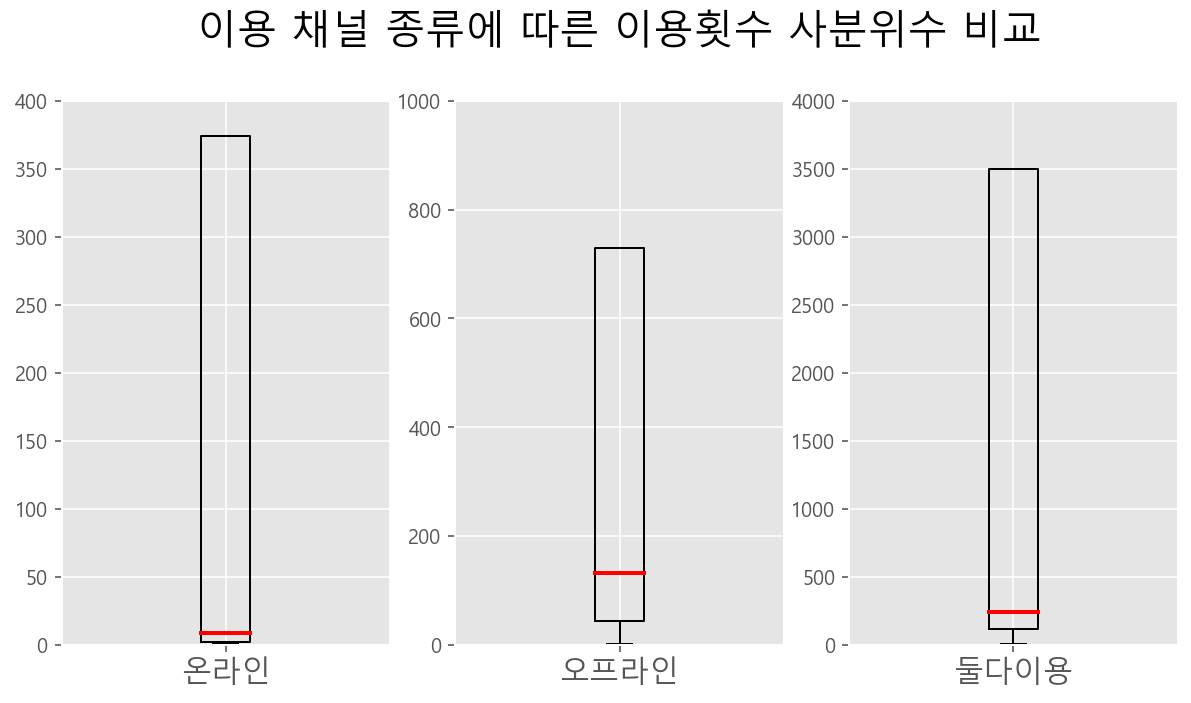

In [51]:
plt.figure(figsize=(10,5))
# 온라인
plt.subplot(1, 3, 1)
plt.boxplot(ch[ch['이용채널'] == '온라인']['이용횟수'].describe(), medianprops=dict(color='r', linewidth=2))
plt.xticks([1],['온라인'], fontsize=15)
plt.ylim([0, 400])
# 오프라인
plt.subplot(1, 3, 2)
plt.boxplot(ch[ch['이용채널'] == '오프라인']['이용횟수'].describe(), medianprops=dict(color='r', linewidth=2))
plt.title('이용 채널 종류에 따른 이용횟수 사분위수 비교\n', fontsize=20)
plt.xticks([1],['오프라인'], fontsize=15)
plt.ylim([0, 1000])
# 둘다
plt.subplot(1, 3, 3)
plt.boxplot(ch[ch['이용채널'] == '둘다이용']['이용횟수'].describe(), medianprops=dict(color='r', linewidth=2))
plt.xticks([1],['둘다이용'], fontsize=15)
plt.ylim([0, 4000])
plt.show()

- 유형1   
    - 온라인만을 이용하는 고객은 방문 횟수가 매우 낮음 ( 3사분위까지 5번 안쪽 )  
        - 때문에 온라인만 이용하는 고객의 비율이 높은 유형1의 경우 RFM시각화가 이전과 같은 결과를 보이는 것임  
        - 해당 유형에는 온라인과 오프라인에 대한 복합적인 마케팅 전략이 필요할듯함  
- 유형2,4  
    - 위의 사분위수 그래프를 보면 오프라인만 이용하는 고객보다 온라인과 오프라인 모두 사용하는 고객의 경우 방문 횟수가 더 높음을 알 수 있다.  
    - 따라서 이전 RFM그래프에서 유형2의 문제였던 방문횟수를 온라인 홍보를 통해 올릴 수 있을 것이라 판단됨  
    - 파이차트를 보았을 때, 유형2의 형태를 유형4의 형태로 변할 수 있도록 마케팅을 진행한다면 보다 충성도가 높은 고객을 유치할 수 있을 것이라고 판단됨  

### 구매 품목 살펴보기

In [52]:
data[(data['고객번호'].isin(customer_3)) & (data['채널구분'] == 2)].groupby('중분류명').count().sort_values('고객번호', ascending=False)[:10].index

Index(['없음', '우유', '국산과일', '스낵류', '잎채소', '두부/콩나물류', '냉동간편식', '요구르트', '봉지라면',
       '레토르트'],
      dtype='object', name='중분류명')

In [53]:
data[(data['고객번호'].isin(customer_2)) & (data['채널구분'] == 2)].groupby('중분류명').count().sort_values('고객번호', ascending=False)[:10].index

Index(['없음', '컴퓨터주변기기', '스킨케어', '냉동간편식', '우유', '국산과일', '계란류', '용기라면', '스낵류',
       '탄산음료'],
      dtype='object', name='중분류명')

- 성별

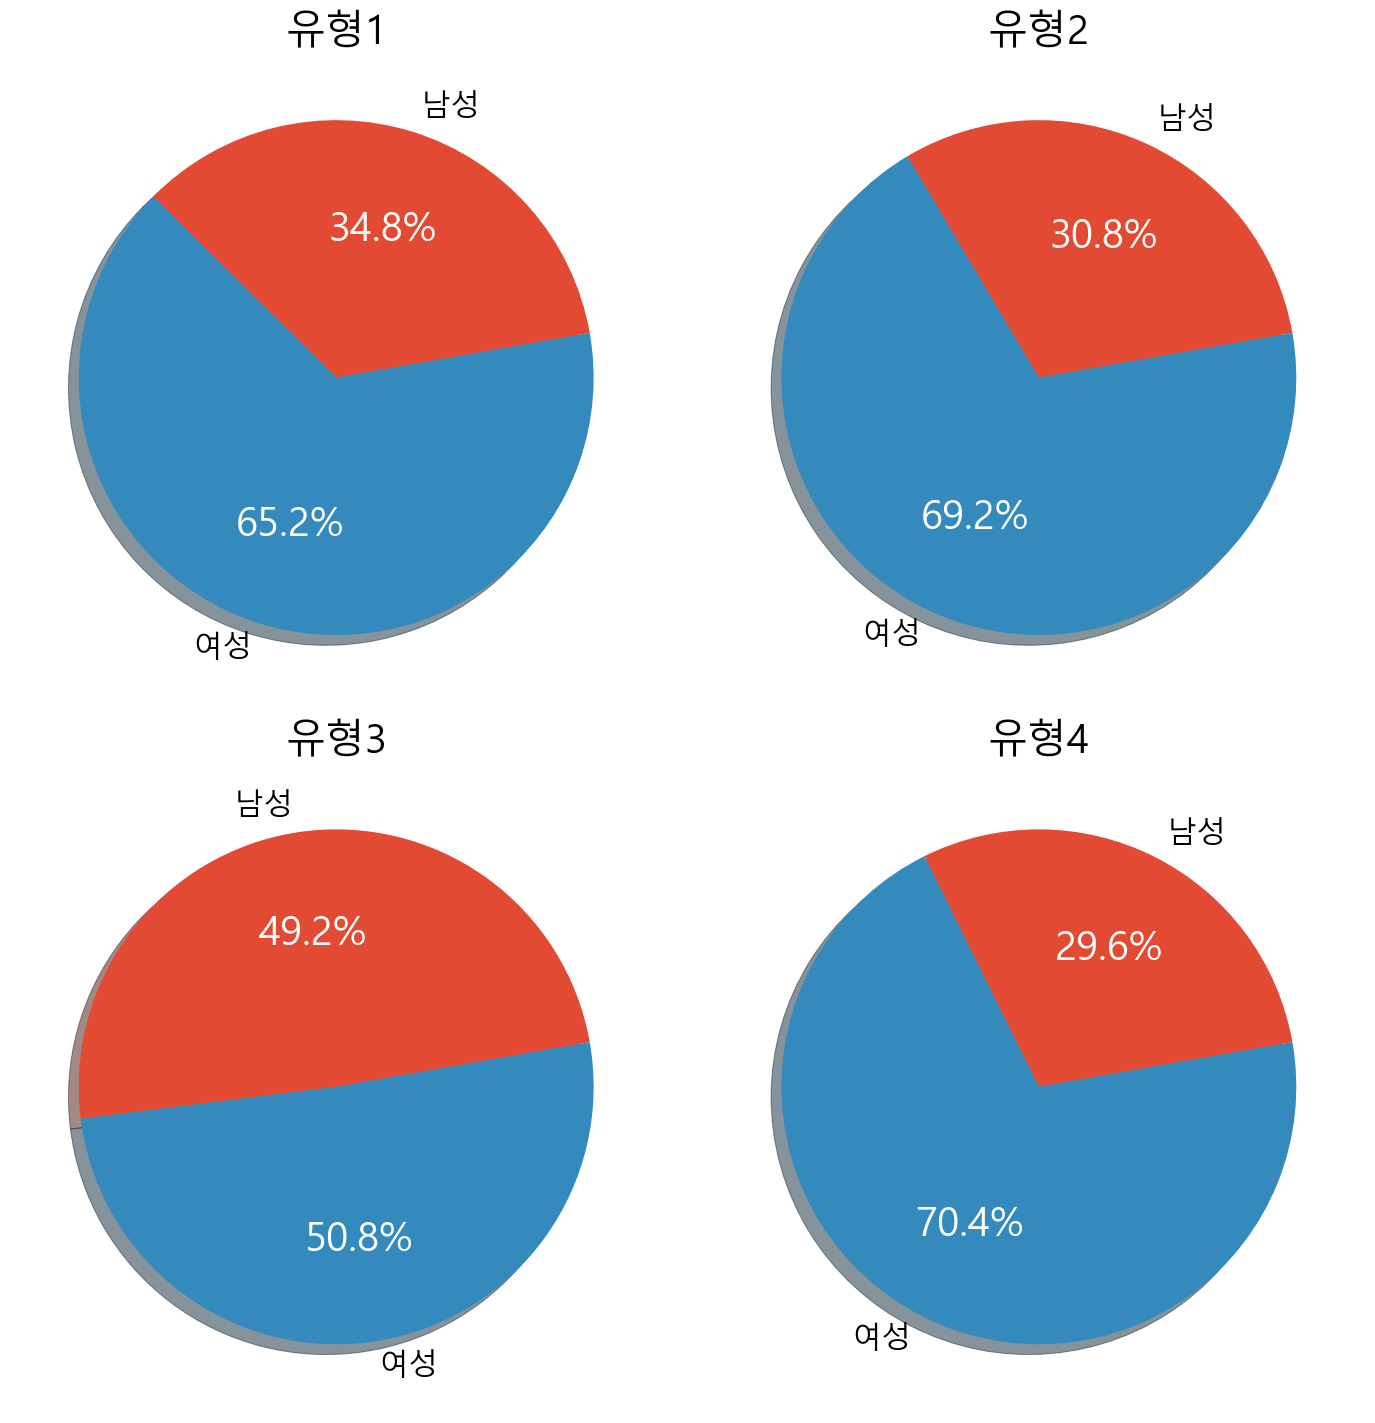

In [54]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
patches_0, texts_0, autotexts_0 = plt.pie(
    demo[demo['고객번호'].isin(customer_0)].groupby('성별').count()['고객번호'] / demo[demo['고객번호'].isin(customer_0)].groupby('성별').count()['고객번호'].sum(),
    labels = ['남성', '여성'],
    labeldistance=1.1,## label이 파이로부터 얼마나 떨어지는가, 1일경우 딱 붙어있음. 
#     explode=[0, 0.1, 0], ##pie가 튀어나오는지 정해줌  
    startangle=10,## 어디에서 시작할지, 정해줌  
    shadow=True, ##그림자 
    autopct='%1.1f%%', ## pi 위에 표시될 글자 형태, 또한 알아서 %로 변환해서 알려줌 
)
plt.title('유형1', size = 20)

plt.subplot(2, 2, 2)
patches_1, texts_1, autotexts_1 = plt.pie(
    demo[demo['고객번호'].isin(customer_1)].groupby('성별').count()['고객번호'] / demo[demo['고객번호'].isin(customer_1)].groupby('성별').count()['고객번호'].sum(),
    labels = ['남성', '여성'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형2', size = 20)

plt.subplot(2, 2, 3)
patches_2, texts_2, autotexts_2 = plt.pie(
    demo[demo['고객번호'].isin(customer_2)].groupby('성별').count()['고객번호'] / demo[demo['고객번호'].isin(customer_2)].groupby('성별').count()['고객번호'].sum(),
    labels = ['남성', '여성'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형3', size = 20)

plt.subplot(2, 2, 4)
patches_3, texts_3, autotexts_3 = plt.pie(
    demo[demo['고객번호'].isin(customer_3)].groupby('성별').count()['고객번호'] / demo[demo['고객번호'].isin(customer_3)].groupby('성별').count()['고객번호'].sum(),
    labels = ['남성', '여성'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형4', size = 20)

for t1, t2, t3, t4 in zip(autotexts_0, autotexts_1, autotexts_2, autotexts_3):
    t1.set_color("white")
    t1.set_fontsize(20)
    t2.set_color("white")
    t2.set_fontsize(20)
    t3.set_color("white")
    t3.set_fontsize(20)
    t4.set_color("white")
    t4.set_fontsize(20)

for t1,t2,t3,t4 in zip(texts_0, texts_1, texts_2, texts_3):
    t1.set_fontsize(15)
    t2.set_fontsize(15)
    t3.set_fontsize(15)
    t4.set_fontsize(15)
    
plt.tight_layout()
plt.show()


- 타 유형 대비 유형3은 남성의 비율이 높음을 알 수 있음

### 이탈 위험비율

- 유형별 이탈 위험률 분포

- 최종 접속 경과일 (최종 구매 경과일)

In [57]:
data['날짜'] = pd.to_datetime(data['날짜'])
imp = data.sort_values(by=['날짜'], ascending=[True]).groupby(['고객번호', '날짜'])[['채널구분']].count().reset_index().groupby('고객번호')['날짜'].agg([('구매일수', 'count')]).reset_index()
# 딱 하루만 구매한 고객들
oneday_buyer = list(imp[imp['구매일수']==1]['고객번호'])
# 고객별 구매 날짜
imp2 = data.groupby(['고객번호', '날짜'])[['채널구분']].count().drop('채널구분', axis=1).reset_index()
# 최근 구매일자별 최근 상위 2개를 구함
result = imp2.sort_values(by=['고객번호', '날짜']).groupby('고객번호')['날짜'].apply(set).reset_index()
result['최근상위2'] = result['날짜'].apply(lambda x:sorted(list(x))[-2:])
# 상위 두일자의 차이를 구한 후 빼줌
result['최종구매경과일'] = result['최근상위2'].apply(lambda x: abs(x[1] - x[0]) if len(x) == 2 else abs(pd.to_datetime('2021-12-31') - x[0]))
# int로 변환
result['최종구매경과일'] = result['최종구매경과일'].dt.days
# 결과 도출
result = result[['고객번호','최종구매경과일']];result

,고객번호,최종구매경과일
0,M000034966,54
1,M000059535,303
2,M000136117,14
3,M000201112,107
4,M000225114,6
...,...,...
29869,M999708287,58
29870,M999770689,13
29871,M999849895,47
29872,M999926092,76


- 평균 구매일 주기

In [59]:
diff_final_buy = data.groupby('고객번호')['날짜'].diff().fillna('0').astype(str)
diff_final_buy = diff_final_buy.apply(lambda x: abs(int(x.split()[0])))
data['diff'] = diff_final_buy
f = data.groupby(['고객번호'])[['diff']].sum().reset_index()
result['구매간격합'] = f['diff']
result['구매일수'] = imp['구매일수']
result['구매접속간격'] = result['구매일수']-1

- 평균 구매주기

In [60]:
# 평균구매주기
mean_buy_cycle = [] 

for i in range(result.shape[0]):
    try:
        mean_buy_cycle.append(result['구매간격합'][i]/result['구매접속간격'][i])

    except ZeroDivisionError:
        mean_buy_cycle.append(1)
        continue

len(mean_buy_cycle)

29874

In [61]:
result['평균구매주기'] = mean_buy_cycle
# 딱 하루 구매한 사람들은 평균구매주기를 1로 대체
result['평균구매주기'].fillna(1, inplace=True)

- 이탈위험비율  
    - [최종구매경과일] / [평균구매주기]

In [62]:
result['이탈위험비율'] = result['최종구매경과일']/result['평균구매주기']
churn = result[['고객번호', '이탈위험비율']]

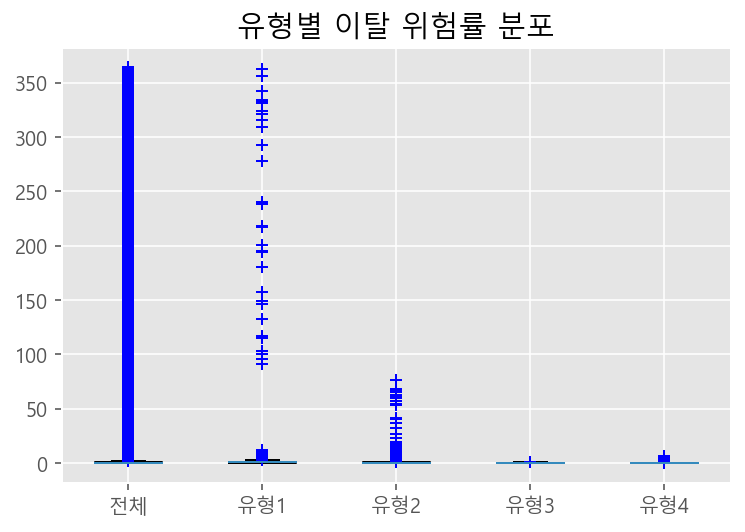

In [63]:
fig, ax = plt.subplots()
ax.boxplot([churn['이탈위험비율'],
            churn[churn['고객번호'].isin(customer_0)]['이탈위험비율'],
           churn[churn['고객번호'].isin(customer_1)]['이탈위험비율'],
           churn[churn['고객번호'].isin(customer_2)]['이탈위험비율'],
           churn[churn['고객번호'].isin(customer_3)]['이탈위험비율']], sym="b+")
plt.title('유형별 이탈 위험률 분포')
plt.xticks([1, 2, 3, 4, 5],['전체', '유형1', '유형2', '유형3', '유형4'])
plt.show()

### 날짜별 활동량 추이 확인

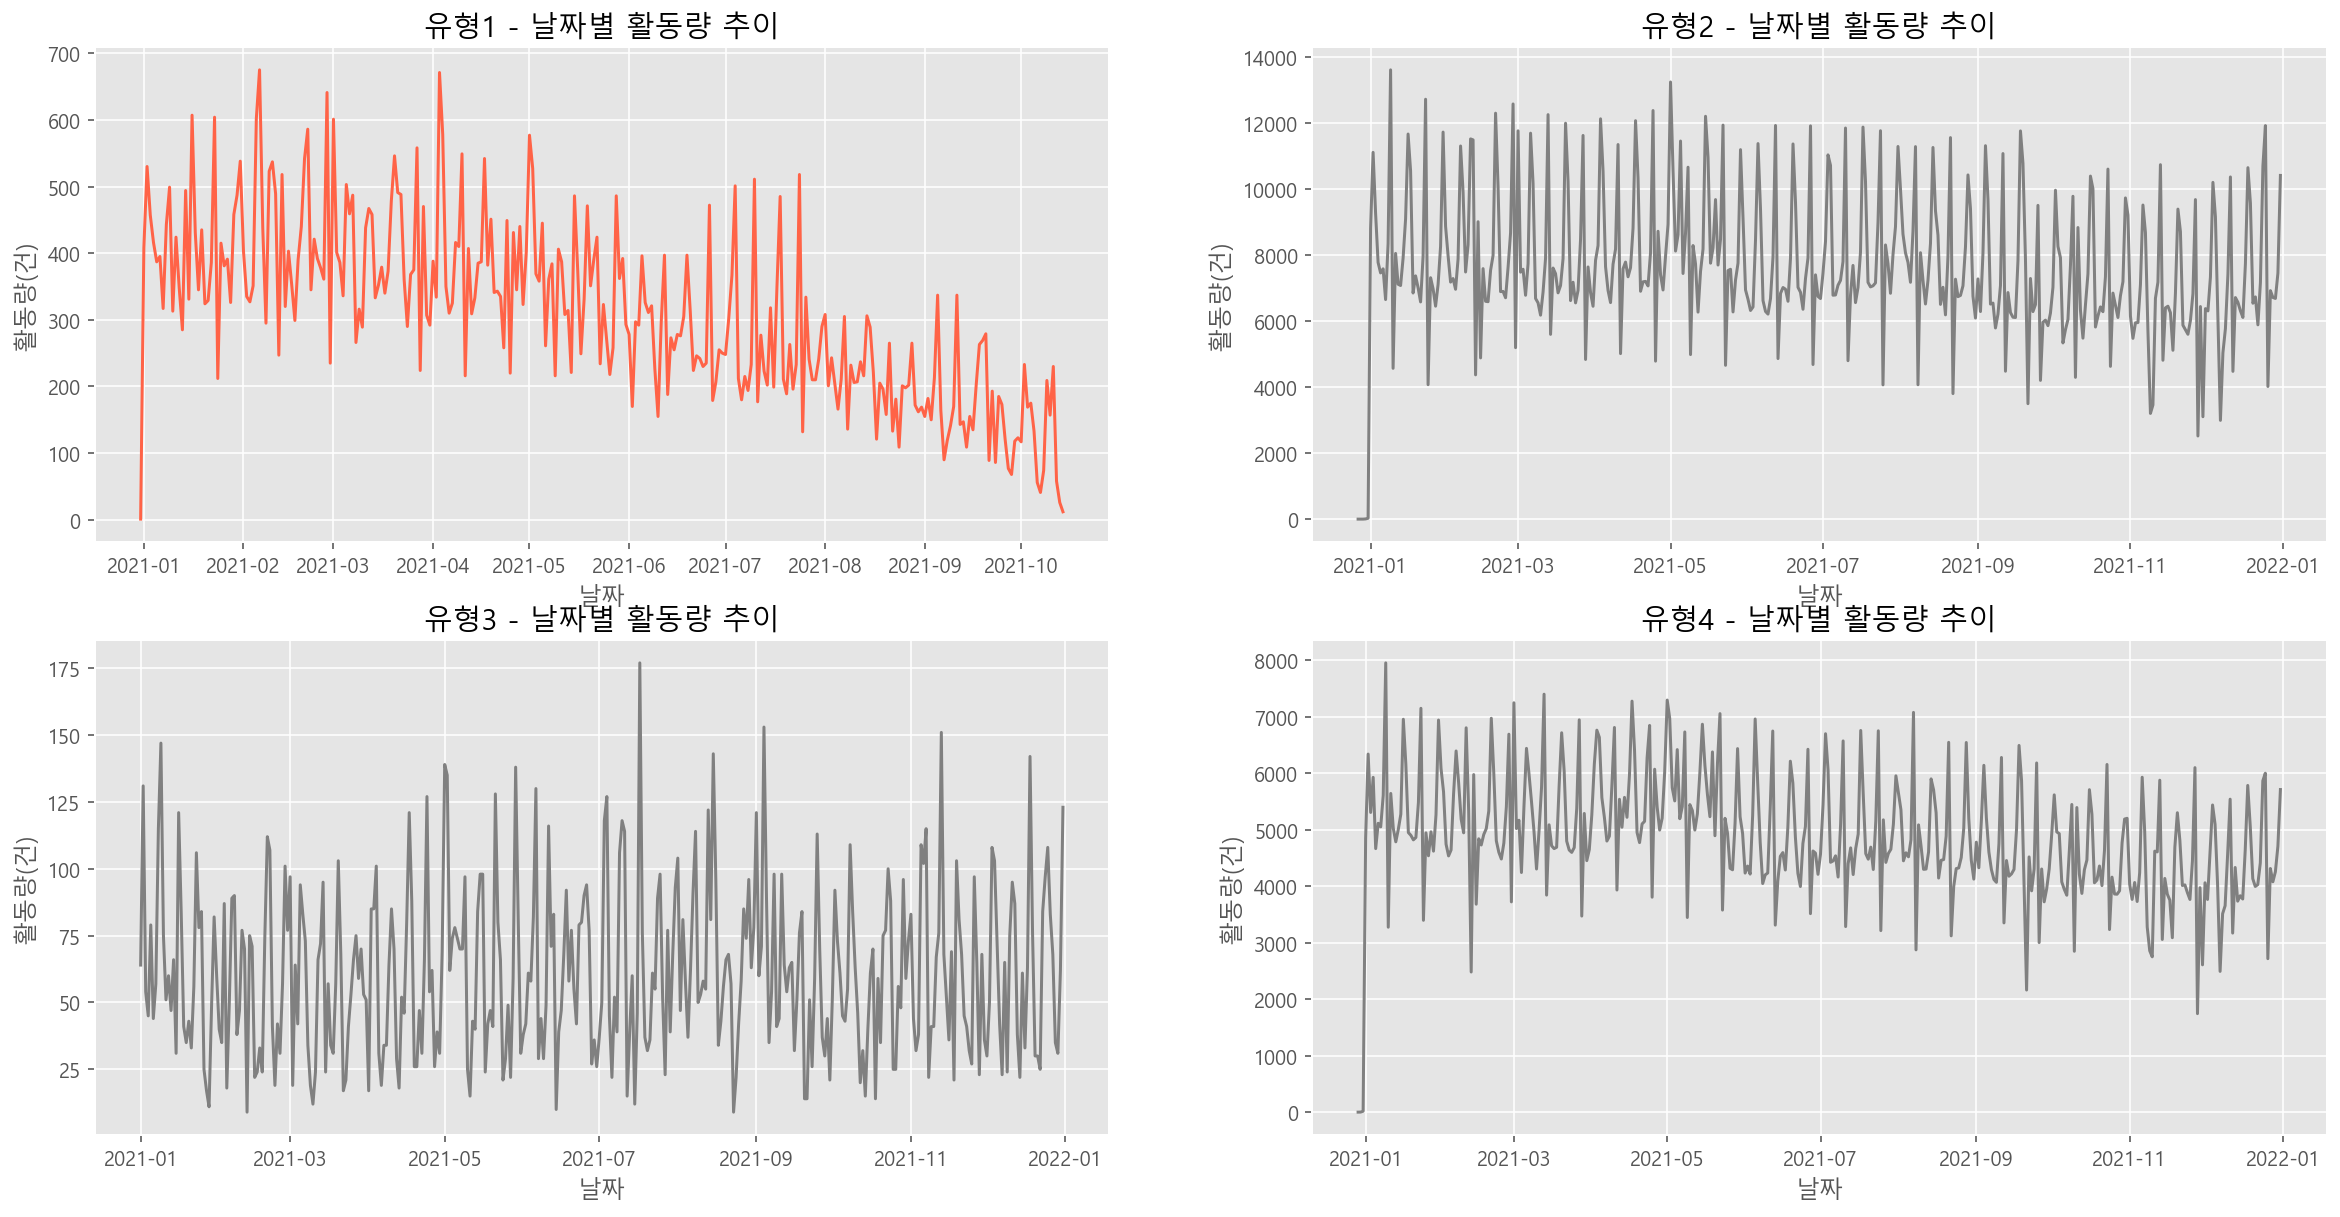

In [81]:
cust0_data = data[data['고객번호'].isin(customer_0)]
cust0_data = cust0_data.groupby('날짜').size().to_frame('count').reset_index()
cust0_data['날짜'] = pd.to_datetime(cust0_data['날짜'])

cust1_data = data[data['고객번호'].isin(customer_1)]
cust1_data = cust1_data.groupby('날짜').size().to_frame('count').reset_index()
cust1_data['날짜'] = pd.to_datetime(cust1_data['날짜'])

cust2_data = data[data['고객번호'].isin(customer_2)]
cust2_data = cust2_data.groupby('날짜').size().to_frame('count').reset_index()
cust2_data['날짜'] = pd.to_datetime(cust2_data['날짜'])

cust3_data = data[data['고객번호'].isin(customer_3)]
cust3_data = cust3_data.groupby('날짜').size().to_frame('count').reset_index()
cust3_data['날짜'] = pd.to_datetime(cust3_data['날짜'])


plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
sns.lineplot(data=cust0_data, x='날짜', y='count', color='tomato')
plt.title('유형1 - 날짜별 활동량 추이')
plt.xlabel('날짜'); plt.ylabel('활동량(건)')

plt.subplot(2, 2, 2)
sns.lineplot(data=cust1_data, x='날짜', y='count', color='gray')
plt.title('유형2 - 날짜별 활동량 추이')
plt.xlabel('날짜'); plt.ylabel('활동량(건)')

plt.subplot(2, 2, 3)
sns.lineplot(data=cust2_data, x='날짜', y='count', color='gray')
plt.title('유형3 - 날짜별 활동량 추이')
plt.xlabel('날짜'); plt.ylabel('활동량(건)')

plt.subplot(2, 2, 4)
sns.lineplot(data=cust3_data, x='날짜', y='count', color='gray')
plt.title('유형4 - 날짜별 활동량 추이')
plt.xlabel('날짜'); plt.ylabel('활동량(건)')

plt.show()

- 이탈 위험 비율과 비슷하게 유형1의 경우 시간이 지날수록 활동량이 줄어드는 모습을 보임

### 코로나 데이터

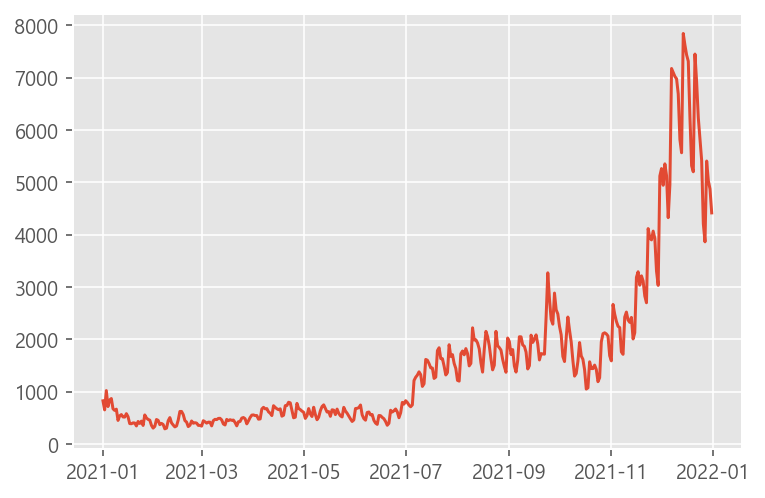

In [82]:
df_covid = pd.read_csv('../data/[한국] 대한민국의 코로나19 총 누적 확진자와 사망자 _ 일간 (2022년 8월 9일).csv')
df_covid = df_covid[df_covid['일자'].apply(lambda x:x[0:4]) == '2021'].reset_index(drop=True)

df_covid['날짜'] = pd.to_datetime(df_covid['일자'])
df_covid = df_covid[['날짜', '신규확진(명)', '신규사망(명)', '누적확진(명)', '누적사망(명)']]
df_covid.columns = ['날짜', '신규확진자', '신규사망자', '누적확진자', '누적사망자']

plt.plot(df_covid['날짜'], df_covid['신규확진자'])
plt.show()

- 유형1의 이용량이 적어지는 이유와 코로나 확진자수의 증가를 함께 확인 해봄

In [83]:
cust0_data.iloc[:,1:].corr(method='pearson')

,count
count,1.0


- 상관계수가 -0.67로 양의 음의 상관계수를 띔

In [84]:
cust0_data = pd.merge(cust0_data, df_covid[['날짜', '누적사망자' , '신규확진자']], how='left', on='날짜')

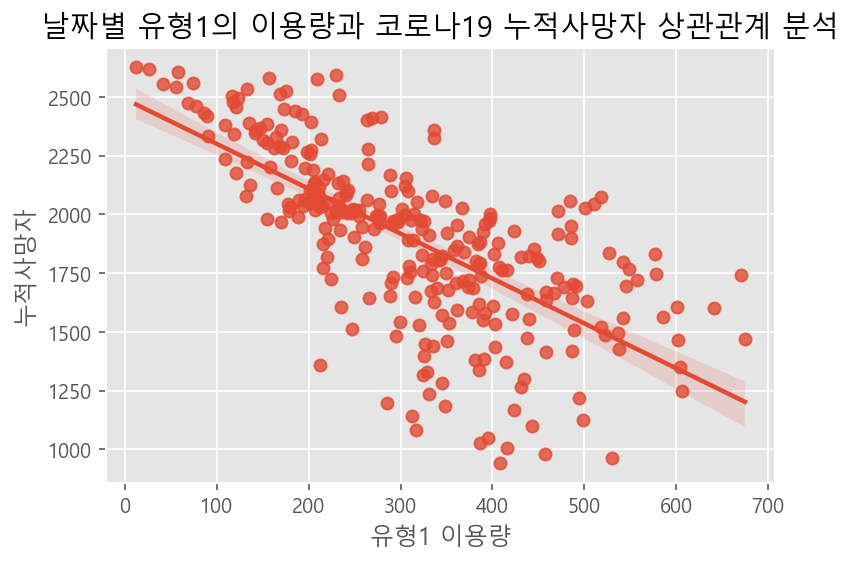

In [85]:
# 누적 사망자와 상관계수 확인
sns.regplot(x='count', y='누적사망자', data=cust0_data)
plt.title('날짜별 유형1의 이용량과 코로나19 누적사망자 상관관계 분석')
plt.xlabel('유형1 이용량')
plt.ylabel('누적사망자')
plt.show()

In [86]:
cust0_data[['count', '누적사망자']].corr(method='pearson')

,count,누적사망자
count,1.000000,-0.688432
누적사망자,-0.688432,1.000000


- 신규확진자

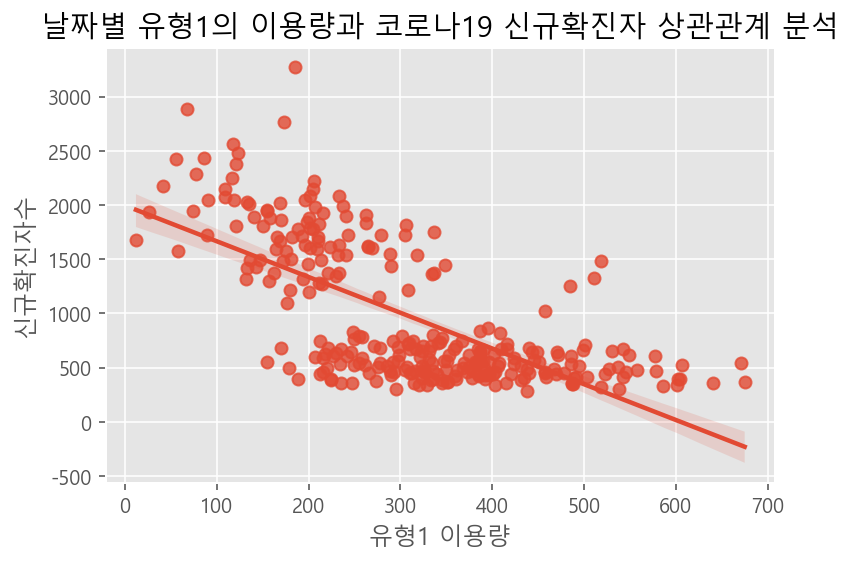

In [88]:
# 그래프로 확인
sns.regplot(x='count', y='신규확진자', data=cust0_data)
plt.title('날짜별 유형1의 이용량과 코로나19 신규확진자 상관관계 분석')
plt.xlabel('유형1 이용량')
plt.ylabel('신규확진자수')
plt.show()

- 다른 유형과 코로나의 상관관계 분석

In [89]:
# 유형2의 이용량과 코로나 신규확진자 데이터를 합쳐줌
cust1_data.columns = ['날짜', 'count']
cust1_data = pd.merge(cust1_data, df_covid[['날짜', '신규확진자']], how='left', on='날짜').dropna().reset_index(drop=True)
cust1_data.iloc[:,1:].corr(method='pearson')

,count,신규확진자
count,1.000000,-0.201292
신규확진자,-0.201292,1.000000


In [90]:
# 유형3의 이용량과 코로나 신규확진자 데이터를 합쳐줌
cust2_data.columns = ['날짜', 'count']
cust2_data = pd.merge(cust2_data, df_covid[['날짜', '신규확진자']], how='left', on='날짜').dropna().reset_index(drop=True)
cust2_data.iloc[:,1:].corr(method='pearson')

,count,신규확진자
count,1.000000,-0.006453
신규확진자,-0.006453,1.000000


In [91]:
# 유형3의 이용량과 코로나 신규확진자 데이터를 합쳐줌
cust3_data.columns = ['날짜', 'count']
cust3_data = pd.merge(cust3_data, df_covid[['날짜', '신규확진자']], how='left', on='날짜').dropna().reset_index(drop=True)
cust3_data.iloc[:,1:].corr(method='pearson')

,count,신규확진자
count,1.000000,-0.338661
신규확진자,-0.338661,1.000000


- 타 유형은 코로나와 큰 관련이 없음을 보임

### 기타

In [92]:
demo['유형'] = demo['성별'] + ' ' + demo['연령대']

In [93]:
trans = data.groupby('고객번호')['영수증번호'].apply(set).reset_index()
trans['거래횟수'] = trans['영수증번호'].apply(lambda x:len(list(x)))
user = demo[demo['고객번호'].isin(trans['고객번호'])].reset_index(drop=True)
user['거래횟수'] = trans['거래횟수']

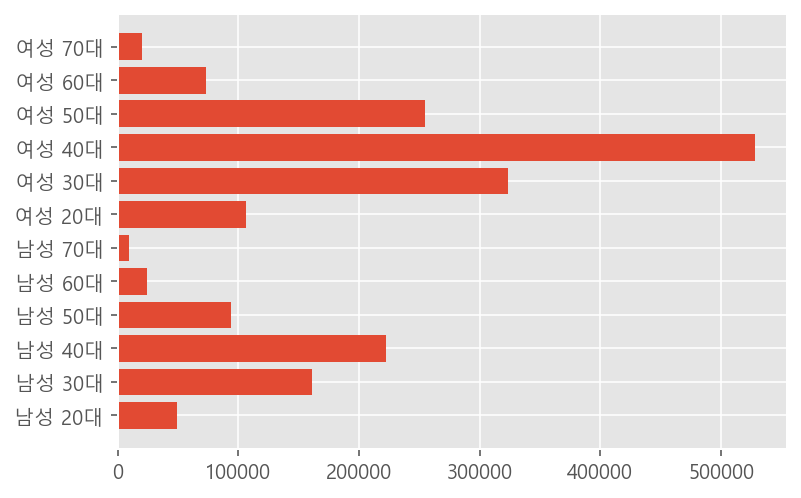

In [94]:
plt.barh(user.groupby('유형')['거래횟수'].sum().reset_index()['유형'], user.groupby('유형')['거래횟수'].sum().reset_index()['거래횟수'])

plt.show()

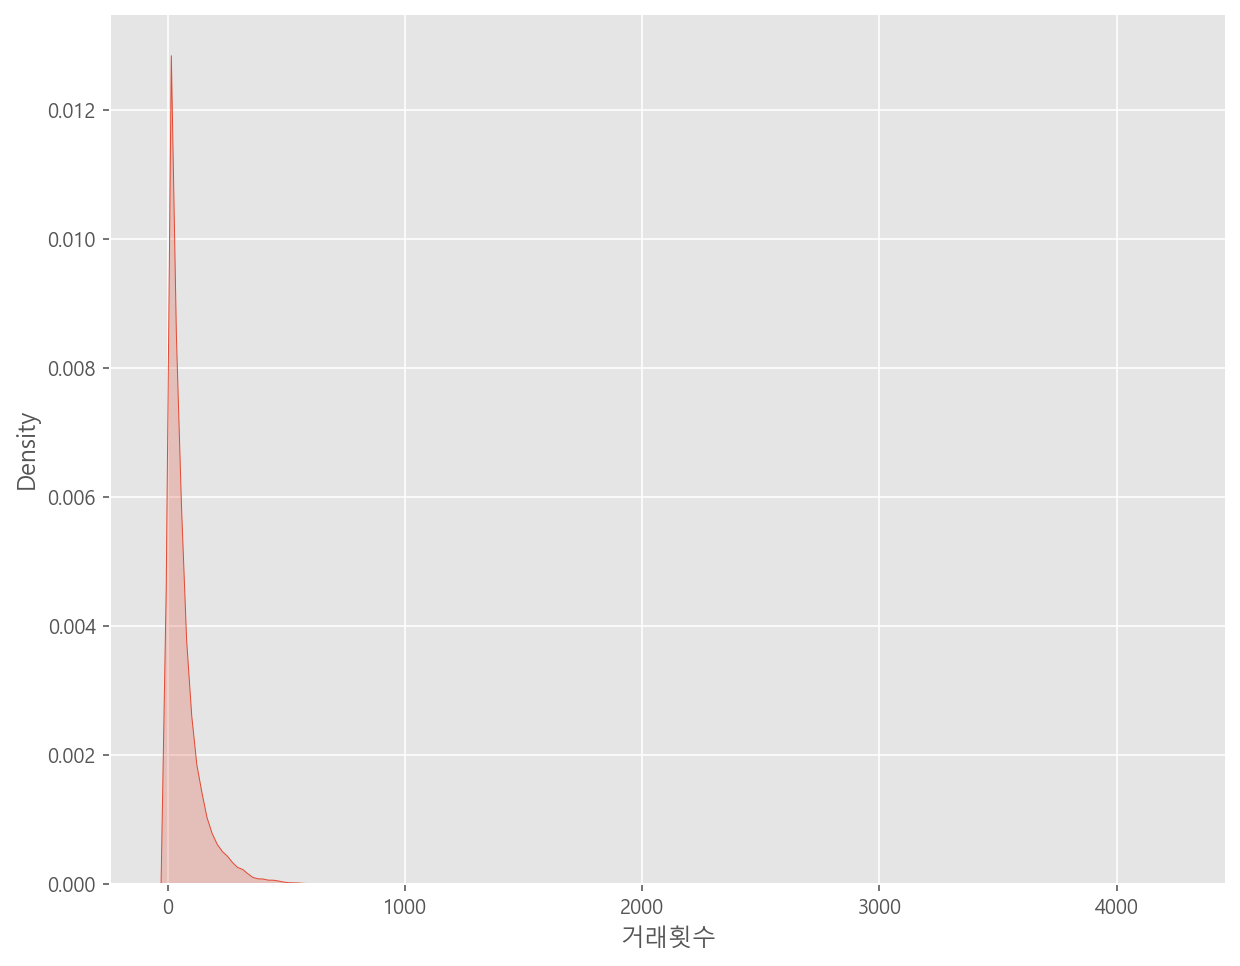

In [95]:
fig = plt.figure(figsize = (10,8))
sns.kdeplot(trans['거래횟수'],shade = True)
plt.show()

In [96]:
user = data.groupby('고객번호')['구매일자'].apply(set).reset_index()
user['첫구매일자'] = user['구매일자'].apply(lambda x:sorted(list(x))[0])

user['회원기간'] = pd.to_datetime('311221') - pd.to_datetime(user['첫구매일자'].astype(str))
user['회원기간'] = user['회원기간'].dt.days

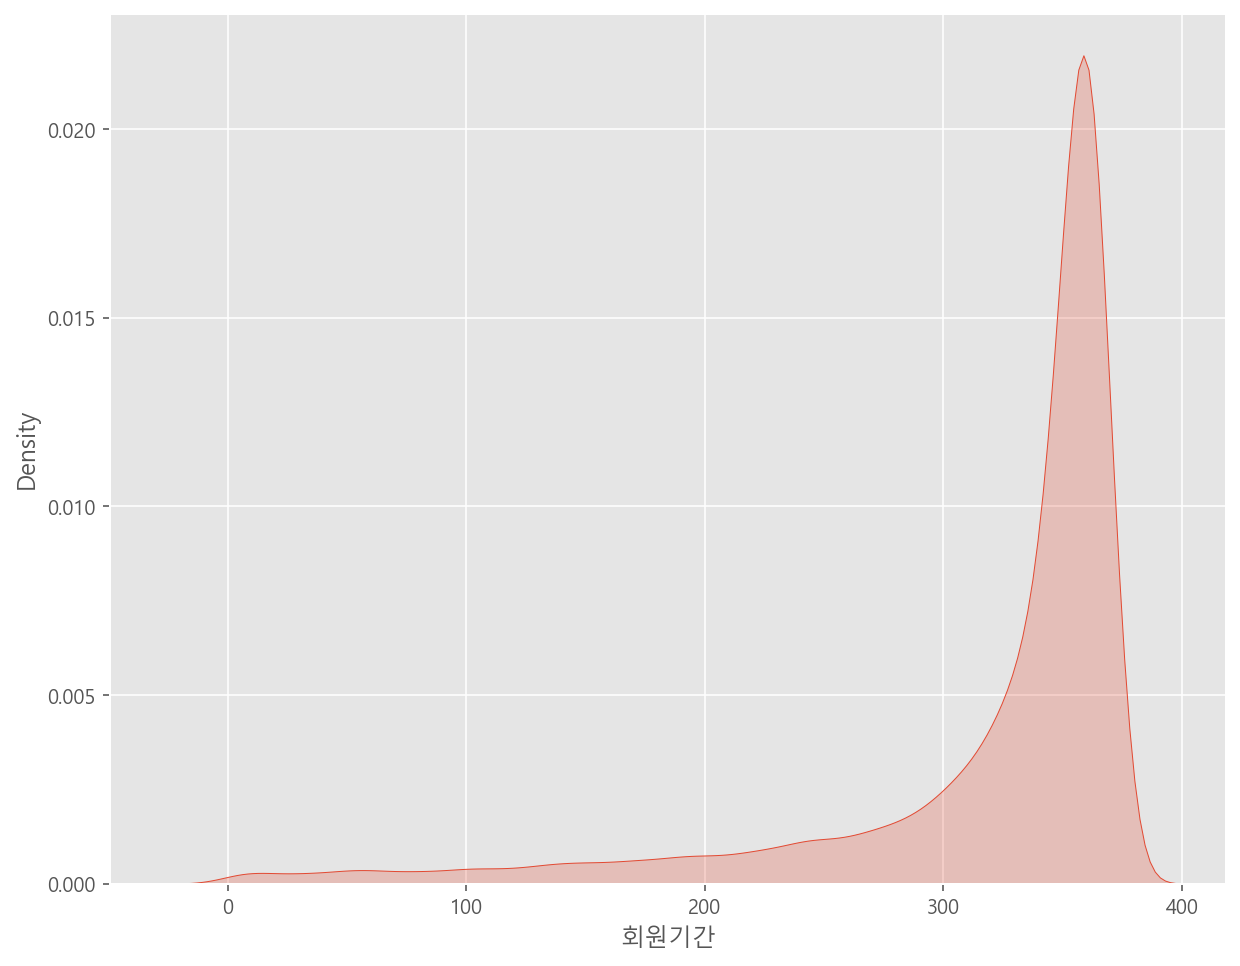

In [97]:
fig = plt.figure(figsize = (10,8))
sns.kdeplot(user['회원기간'],shade = True)
plt.show()

In [98]:
user['거래품목대분류수'] = data.groupby('고객번호')['대분류명'].apply(set).reset_index()['대분류명'].apply(lambda x:len(x))

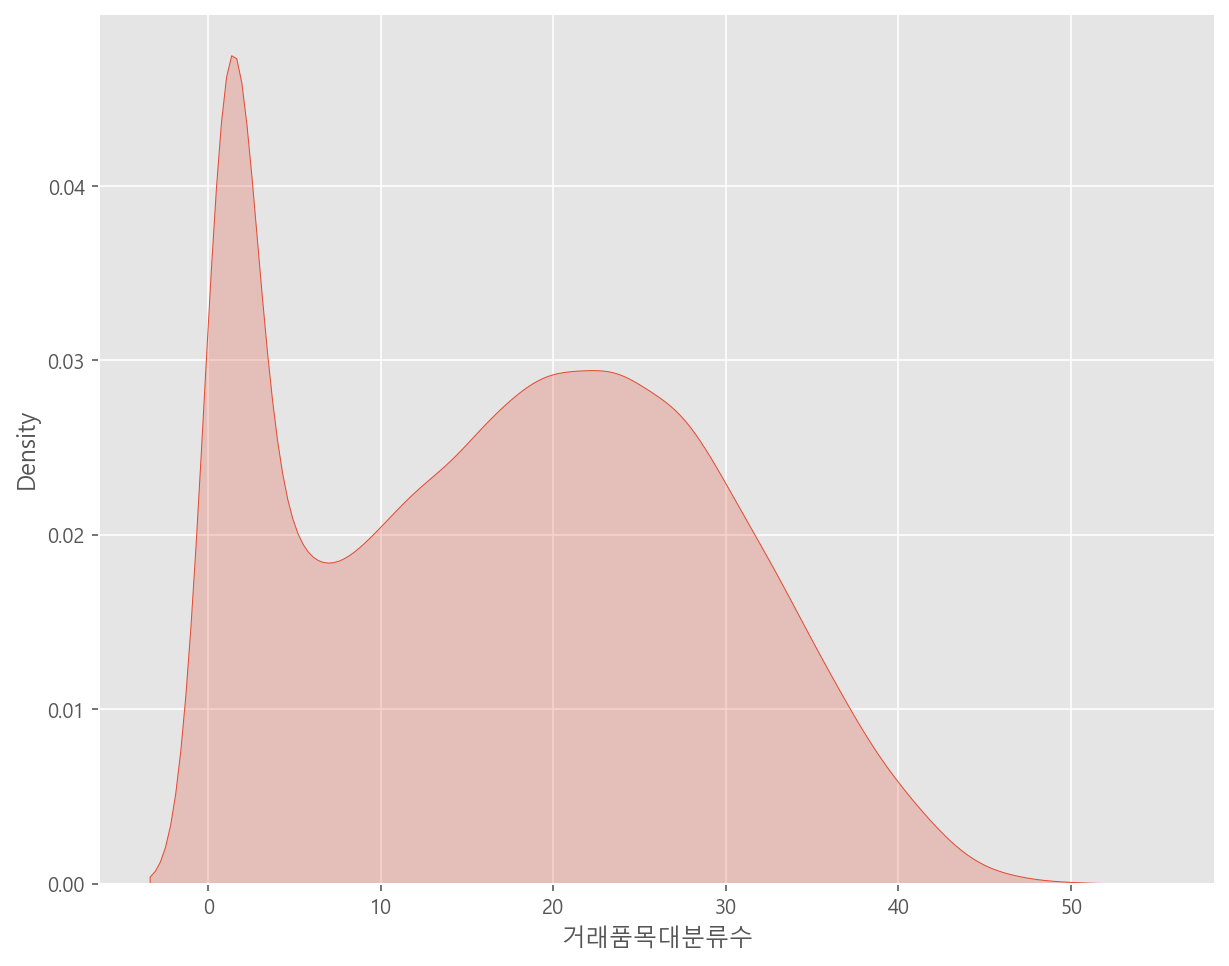

In [99]:
fig = plt.figure(figsize = (10,8))
sns.kdeplot(user['거래품목대분류수'],shade = True)
plt.show()

- 유형별 거래대분류 품목수

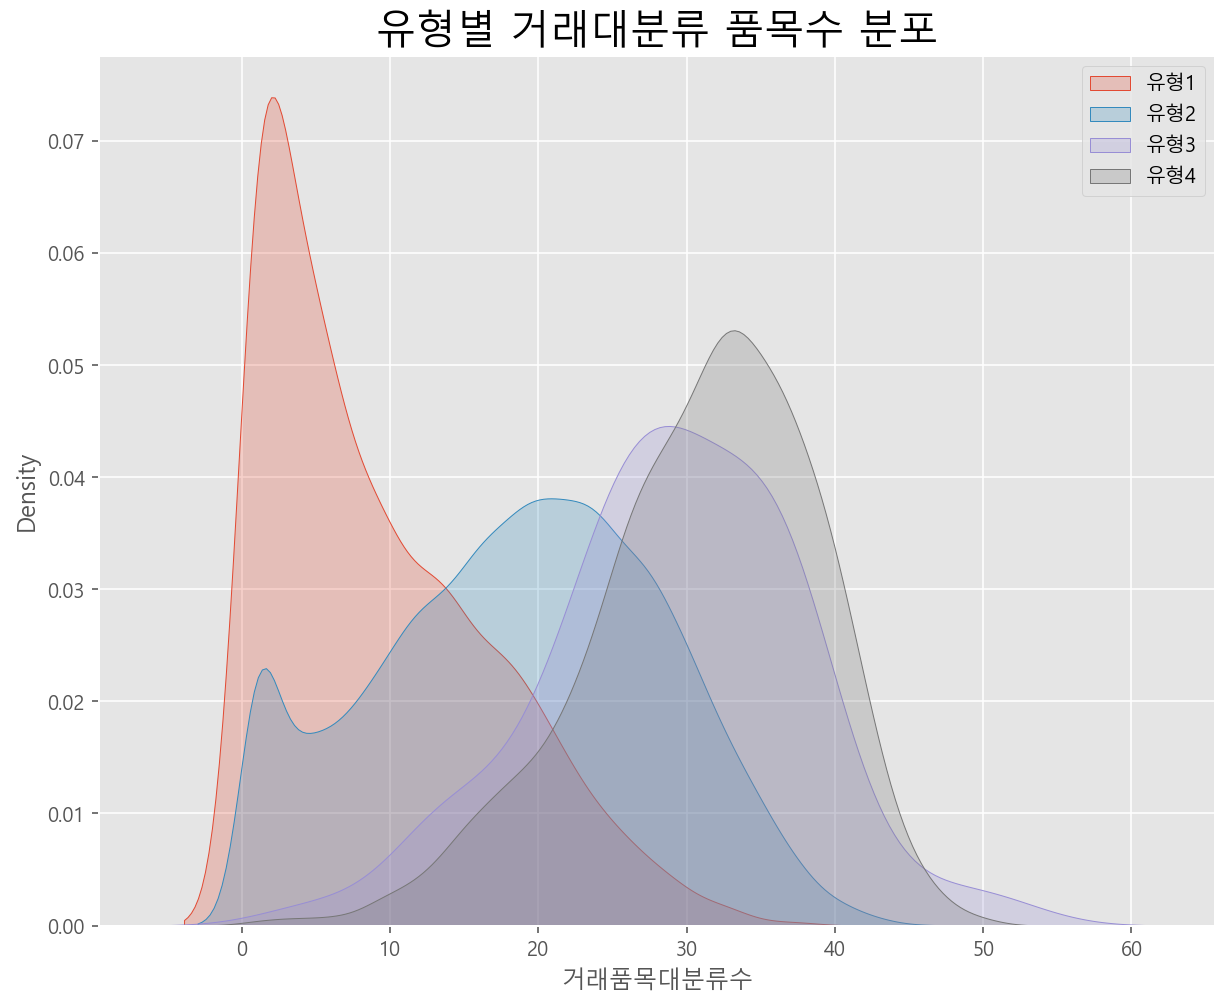

In [100]:
fig = plt.figure(figsize = (10,8))
sns.kdeplot(user[user['고객번호'].isin(customer_0)]['거래품목대분류수'], label = '유형1',shade = True)
sns.kdeplot(user[user['고객번호'].isin(customer_1)]['거래품목대분류수'], label = '유형2',shade = True)
sns.kdeplot(user[user['고객번호'].isin(customer_2)]['거래품목대분류수'], label = '유형3',shade = True)
sns.kdeplot(user[user['고객번호'].isin(customer_3)]['거래품목대분류수'], label = '유형4',shade = True)
plt.title('유형별 거래대분류 품목수 분포', fontsize=20)
plt.legend()
plt.show()

- 유형별 엘페이 사용자의 수를 확인해봄

In [101]:
# 엘페이 사용 여부를 확인해봄
lpay_user = data[data['타입'] == 'Lpay']['고객번호'].unique()
user['Lpay이용여부'] = user['고객번호'].apply(lambda x:'Lpay사용' if x in lpay_user else 'Lpay미사용')

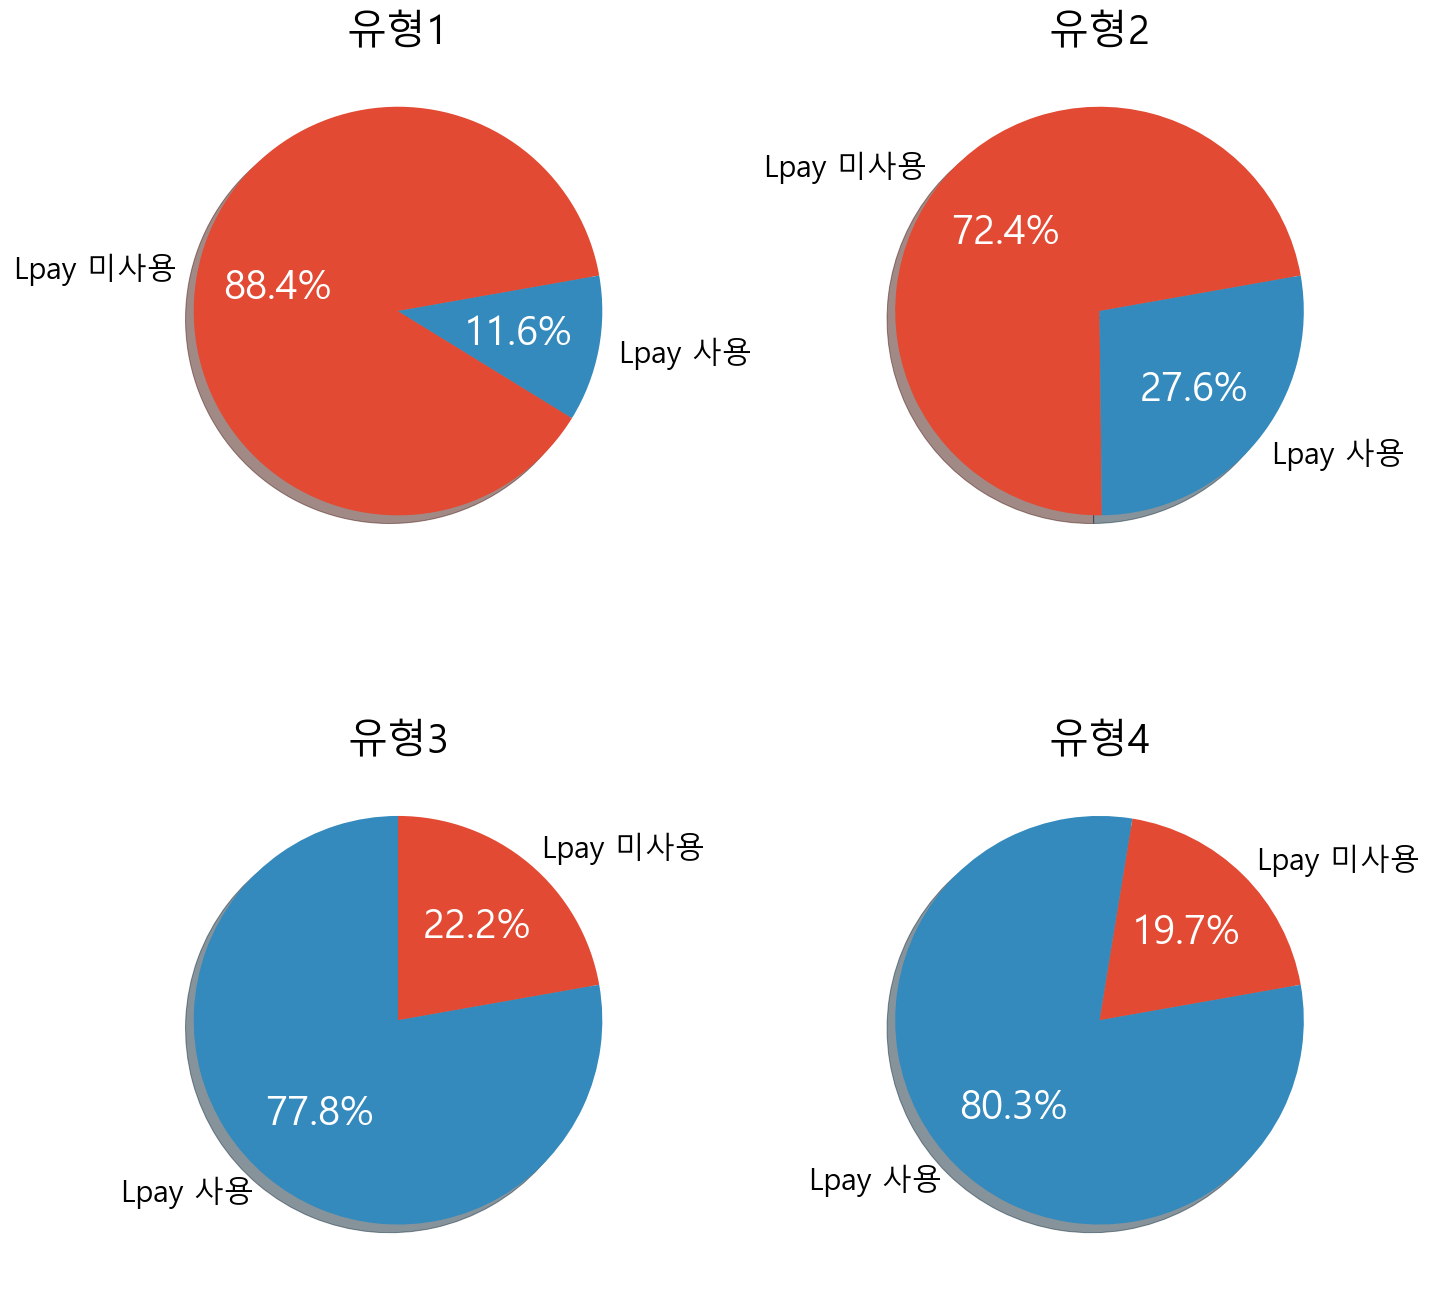

In [102]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
patches_0, texts_0, autotexts_0 = plt.pie(
    user[user['고객번호'].isin(customer_0)].groupby('Lpay이용여부').count().reset_index()['고객번호'],
    labels = ['Lpay 미사용', 'Lpay 사용'],
    labeldistance=1.1,## label이 파이로부터 얼마나 떨어지는가, 1일경우 딱 붙어있음. 
    startangle=10,## 어디에서 시작할지, 정해줌  
    shadow=True, ##그림자 
    autopct='%1.1f%%', ## pi 위에 표시될 글자 형태, 또한 알아서 %로 변환해서 알려줌 
)
plt.title('유형1', size = 20)

plt.subplot(2, 2, 2)
patches_1, texts_1, autotexts_1 = plt.pie(
    user[user['고객번호'].isin(customer_1)].groupby('Lpay이용여부').count().reset_index()['고객번호'],
    labels = ['Lpay 미사용', 'Lpay 사용'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형2', size = 20)

plt.subplot(2, 2, 3)
patches_2, texts_2, autotexts_2 = plt.pie(
    user[user['고객번호'].isin(customer_2)].groupby('Lpay이용여부').count().reset_index()['고객번호'],
    labels = ['Lpay 미사용', 'Lpay 사용'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형3', size = 20)

plt.subplot(2, 2, 4)
patches_3, texts_3, autotexts_3 = plt.pie(
    user[user['고객번호'].isin(customer_3)].groupby('Lpay이용여부').count().reset_index()['고객번호'],
    labels = ['Lpay 미사용', 'Lpay 사용'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형4', size = 20)

for t1, t2, t3, t4 in zip(autotexts_0, autotexts_1, autotexts_2, autotexts_3):
    t1.set_color("white")
    t1.set_fontsize(20)
    t2.set_color("white")
    t2.set_fontsize(20)
    t3.set_color("white")
    t3.set_fontsize(20)
    t4.set_color("white")
    t4.set_fontsize(20)

for t1,t2,t3,t4 in zip(texts_0, texts_1, texts_2, texts_3):
    t1.set_fontsize(15)
    t2.set_fontsize(15)
    t3.set_fontsize(15)
    t4.set_fontsize(15)
    
plt.tight_layout()
plt.show()

- 엘페이

In [103]:
def div_cop(x):
    if x in ['A01', 'A02', 'A03', 'A04', 'A05', 'A06']:
        return '유통사'
    elif x == 'B01':
        return '숙박업종'
    elif x in ['C01', 'C02']:
        return '엔터테이먼트'
    elif x in ['D01', 'D02']:
        return 'F&B'
    elif x == 'E01':
        return '렌탈업종'
    elif x == 'L00':
        return '기타제휴사'
    elif x == 'L01':
        return '비제휴사'

lpay = df_cluster[df_cluster['타입'] == 'Lpay'][['고객번호', '영수증번호', '제휴사', '구매일자', '구매시간', '구매금액']]
lpay['제휴사대분류'] = lpay['제휴사'].apply(div_cop)

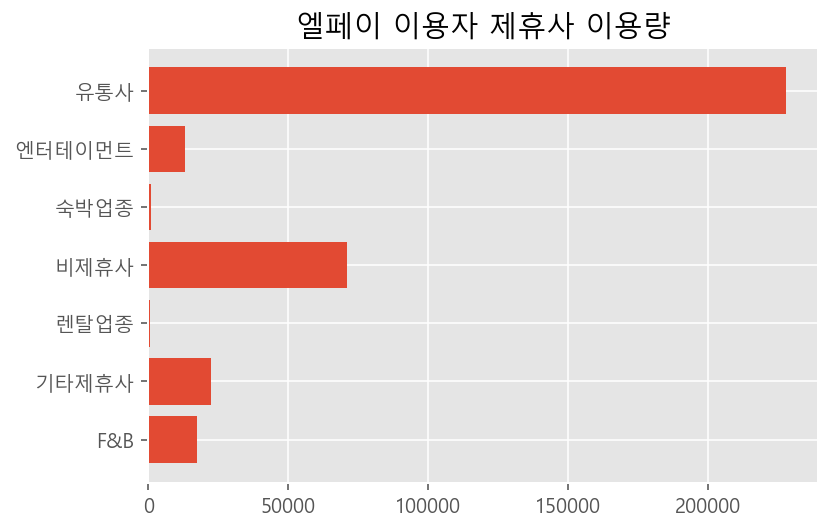

In [104]:
plt.barh(lpay.groupby('제휴사대분류')['고객번호'].count().reset_index()['제휴사대분류'],lpay.groupby('제휴사대분류')['고객번호'].count().reset_index()['고객번호'] )
plt.title('엘페이 이용자 제휴사 이용량')
plt.show()

In [105]:
lpay.groupby('제휴사대분류')['구매금액'].mean()

제휴사대분류
F&B        10320.902017
기타제휴사      60749.871994
렌탈업종      244083.752155
비제휴사       65908.407486
숙박업종      137166.626788
엔터테이먼트     13120.728215
유통사        65119.159930
Name: 구매금액, dtype: float64

- 전체

In [106]:
df_cluster['제휴사대분류'] = df_cluster['제휴사'].apply(div_cop)

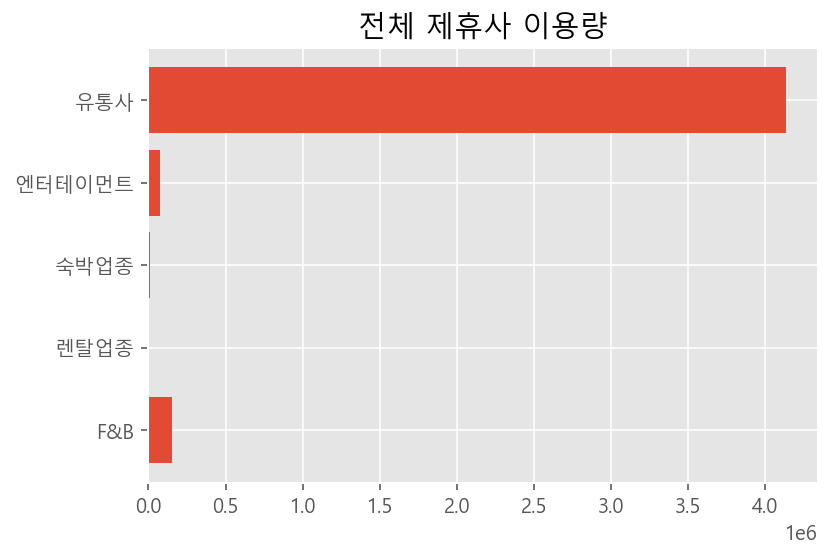

In [107]:
plt.barh(df_cluster[(df_cluster['타입'] == 'Affiliate')|(df_cluster['타입'] == 'Product')].groupby('제휴사대분류')['고객번호'].count().reset_index()['제휴사대분류'],
         df_cluster[(df_cluster['타입'] == 'Affiliate')|(df_cluster['타입'] == 'Product')].groupby('제휴사대분류')['고객번호'].count().reset_index()['고객번호'] )
plt.title('전체 제휴사 이용량')
plt.show()

In [108]:
df_cluster[(df_cluster['타입'] == 'Affiliate')|(df_cluster['타입'] == 'Product')].groupby('제휴사대분류')['구매금액'].mean()

제휴사대분류
F&B        10241.940564
렌탈업종       34619.980673
숙박업종      246224.017036
엔터테이먼트     15151.639856
유통사        23943.214323
Name: 구매금액, dtype: float64

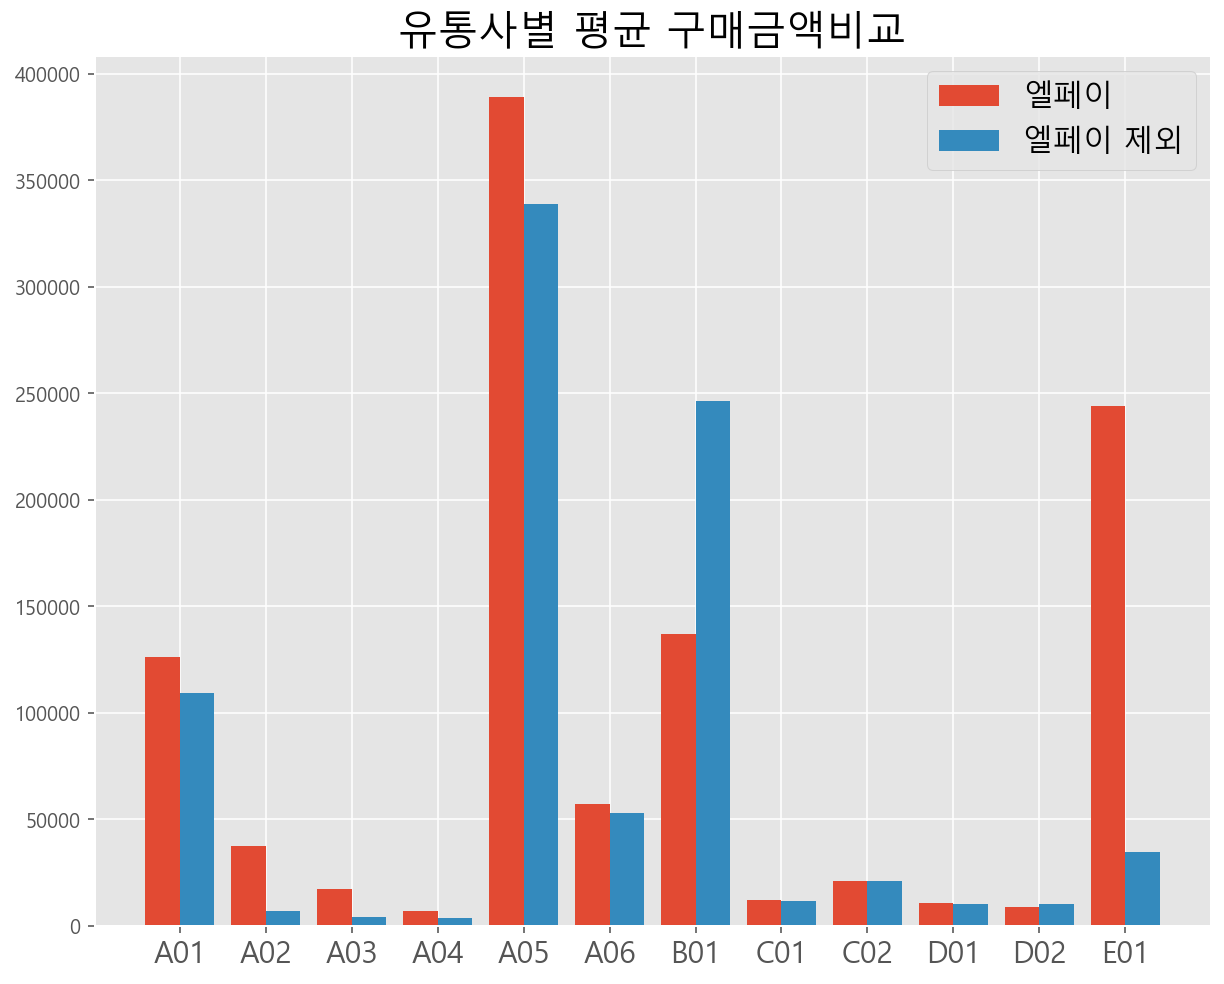

In [109]:
# 각 제휴사별 평균 구매금액 분포
x = np.arange(12)

plt.figure(figsize=(10, 8))
# 전체
plt.bar(x-0.2, lpay.groupby('제휴사')['구매금액'].mean()[:-2], 0.4, label='엘페이')
# 유형1
plt.bar(x+0.2, df_cluster[(df_cluster['타입'] == 'Affiliate')|(df_cluster['타입'] == 'Product')].groupby('제휴사')['구매금액'].mean(), 0.4, label='엘페이 제외')


plt.xticks(x, lpay.groupby('제휴사')['구매금액'].mean().reset_index()['제휴사'][:-2], fontsize = 15)
plt.legend(fontsize = 15)
plt.title('유통사별 평균 구매금액비교', fontsize=20)
plt.show()